 This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e.,  origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator. It considers a toy network, called quickstart detailed here:
 https://sumo.dlr.de/docs/Tutorials/quick_start.html

# Install sumo

In [75]:

#reimporting help to ensure the latest version is used
import importlib
import helpers_od_calibration
importlib.reload(helpers_od_calibration)

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/helpers_od_calibration.py'>

Mount GDrive

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


Install SUMO

In [76]:

import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci


#print(SUMO_HOME)
#print(SUMO_HOME.parents[1])
#print(SUMO_HOME.parents[2])

import json, shutil

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib


base_path = '/Users/inesbenhamza/Desktop/Sumo_od_calibration'
# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain any spaces.")

os.chdir(base_path)

# Macros / utils

In [77]:
# install missing packages
#!pip install gpytorch
#!pip install botorch
#!pip install matplotlib
#!pip install pandas
#!pip install seaborn 

# library import 

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize



from helpers_od_calibration import (load_kwargs_config,
                    compute_nrmse_counts_all_edges,
                    parse_loop_data_xml_to_pandas,
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    )

%matplotlib inline

# Create GT (ground truth) scenario

In [79]:
config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 5,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_bo_vanilla',


In [80]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"]) #Ground Truth OD 

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0) #Fixed routes

Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml
total GT demand:  2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv


Simulate the GT scenario to obtain the GT traffic statistics

In [81]:
#not installed in virtual env 
#import sys
#!{sys.executable} -m pip install lxml

### simulate the GT scenario to obtain the GT traffic statitics 

In [82]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'
print(simulation_gt_run_path)

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True) #Creates directory for ground truth simulation outputs

output/quickstart_bo_vanilla/ground_truth


In [83]:

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path) 

print(base_od)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count  data
0  taz91  taz93  500.0  None
1  taz91  taz94  500.0  None
2  taz92  taz93  900.0  None
3  taz92  taz94  900.0  None


### Run simulation to produce the traffic on eachlink given the ground trutch demand for each od pair, so here we simulate the GT scenario to obtain the GT traffic statitics 

In [84]:
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])


od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/n

Read and process the GT simulation outputs

In [85]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)


#accessing ground truth (link flow we are trying to recover)
print(gt_edge_data)

Number of GT edges: 14
output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml
   edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
1       D4                1800.0                    8.527143
6      L14                1800.0                   11.386250
11      L4                1800.0                    9.915000
2       D5                1400.0                   11.488750
3       D7                1400.0                   11.294444
4      L10                1400.0                   11.441250
9      L18                1400.0                   11.635000
12      L5                1400.0                   11.353750
13      L7                1400.0                   11.046667
0       D2                1000.0                    8.445000
5      L12                1000.0                   11.410000
10      L2                1000.0                   10.498000
8      L16                 900.0                   11.863750
7      L15                 500.0                   1

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)

cpu
4


## implementation of mogp (fitting ) : fitting gp independently for each of the link flows (all using the OD matrix as an input), and concatenate them as a list Inspect link-level GP fitting result



wrap independent GP models into a convenient Multi-Output GP model using a ModelList.
Here we treat each outcome independently. This is equivalent to setting up a separate GP for each outcome. 


declare the parameters space

In [87]:
#device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dtype = torch.float64

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) #create a tensor [2, 4 ] filled with 0s and 2000s

# to make sure only physocally meaningful demand values are explored 
#    # Min: no vehicles and Max: 2000 vehicles per OD
#prevent suggesting unrealistic values 

print("bounds matrix:",bounds)

Using device: cpu
4
bounds matrix: tensor([[   0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000.]], dtype=torch.float64)


## Create and simulate a sample of initial input points (i.e., ODs).
RUN SOBOL SAMPLING (COLLECT DATA)

5 samples are used as inital training data so we will get 5 initial points training prediction 

1 observation → GP can't learn patterns
5 observations → GP can start modeling relationships
More initial samples → better initial GP, but more expensive

In [88]:
# Sample according to Sobol, drawn are quasi random so need multiple restart !! 
# quasi bc they cover the aparameters space more evenly than pure randomness, they avoid lcuster and gaps so better coverage of space 
#it ensure we can explore differnt regions 
#better initial data, bette gp, better optimization 

seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed) #Sobol sequences are an example of low discrepancy quasi-random sequences.
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #5 samples of 4 dimensions each


print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize

Random seed set to 42
torch.Size([5, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374]], dtype=torch.float64)
4


# computing the loss per edge with the simulated innitial sobol OD vector / Training points 

In [89]:
from helpers_od_calibration import compute_nrmse_per_edge

ods_epsilon = [] # for storing the different od matrices generated
loss_all = []  # Overall loss for monitoring
loss_per_edge_all = []  # Per-edge losses
batch_data_i = []
edge_counts_all = []

edge_ids = None
base_od = gt_od_df.copy() # Ground Truth OD
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i, x in enumerate(train_X0.tolist()):
    print(f"\n########### OD Sample {i+1}/{config['n_init_search']} ###########")
    print(f"OD config: {x}")

    # Create output directory
    simulation_run_path_init = f'{config["simulation_run_path"]}/initial_search'
    Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

    new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
    prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

    # Generate OD
    curr_od = np.array(x)
    print(f'Total expected demand: {np.sum(curr_od):.1f} vehicles')

    # Create OD xml file
    base_od_temp = base_od.copy()  # ← Fixed: Don't modify base_od directly
    base_od_temp['count'] = curr_od
    base_od_temp['count'] = [round(elem, 1) for elem in base_od_temp['count']]
    base_od_renamed = base_od_temp.rename(columns={'fromTaz':'from', 'toTaz':'to'})
    create_taz_xml(new_od_xml, base_od_renamed, config["od_duration_sec"], base_path)
    
    ods_epsilon.append(curr_od)

    # Run SUMO simulation
    print("Running SUMO simulation...")
    simulate_od(new_od_xml,
                prefix_output_init,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"])

    # Parse edge data
    sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
        base_path, sim_edge_out, prefix_output_init, config["SUMO_PATH"]
    )
    
    # Get edge_ids from first iteration in order to use it for fitting the gps
    if edge_ids is None:
        edge_ids = curr_loop_stats['edge_id'].tolist()
        print(f"Using {len(edge_ids)} edges: {edge_ids}")
    
    # Extract edge counts
    curr_edge_counts = curr_loop_stats.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
    edge_counts_all.append(curr_edge_counts)
    
    # Compute overall loss (for monitoring)
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
    loss_all.append(curr_loss)
    
    # Compute per-edge loss
    curr_loss_per_edge = compute_nrmse_per_edge(gt_edge_data, curr_loop_stats, edge_ids)
    loss_per_edge_all.append(curr_loss_per_edge)
    
    print(f"Overall loss (NRMSE): {curr_loss:.6f}")
    print(f"Per-edge losses - min: {curr_loss_per_edge.min():.6f}, max: {curr_loss_per_edge.max():.6f}, mean: {curr_loss_per_edge.mean():.6f}")

    # Store data from original code
    df_curr = pd.DataFrame(curr_od.reshape(1, dim_od),
                          columns=[f"x_{i+1}" for i in range(dim_od)])
    df_curr['loss_overall'] = curr_loss
    
    # Add edge counts and per-edge losses
    for j, edge_id in enumerate(edge_ids):
        df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
        df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
    
    batch_data_i.append(df_curr)

# Save initial dataset
df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
initial_csv_path = f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
df_initial_bo.to_csv(initial_csv_path, index=None)
print(f"\nSaved initial results to: {initial_csv_path}")



########### OD Sample 1/5 ###########
OD config: [1995.026707649231, 208.73278379440308, 1645.9577083587646, 838.8643264770508]
Total expected demand: 4688.6 vehicles
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml
Running SUMO simulation...
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.73
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search

# simulated edge count for the training OD 

In [90]:
for sim_idx, sim_counts in enumerate(edge_counts_all):
    print(f"\nSimulation : {sim_idx}")
    for edge_id, count in zip(edge_ids, sim_counts):
        print(f"{edge_id}: {count}") # simulated link level, per link traffic counts for each of the 5 simulations
#so thats what we get when running the simualtin with the 5 different od matrices


Simulation : 0
D2: 2204.0
D4: 2485.0
D5: 3641.0
D7: 1048.0
L10: 1048.0
L12: 2204.0
L14: 2485.0
L15: 1995.0
L16: 839.0
L18: 3641.0
L2: 2204.0
L4: 2485.0
L5: 3641.0
L7: 1048.0

Simulation : 1
D2: 2581.0
D4: 1379.0
D5: 1051.0
D7: 2909.0
L10: 2909.0
L12: 2581.0
L14: 1379.0
L15: 905.0
L16: 1233.0
L18: 1051.0
L2: 2581.0
L4: 1379.0
L5: 1051.0
L7: 2909.0

Simulation : 2
D2: 1136.0
D4: 1744.0
D5: 1832.0
D7: 1048.0
L10: 1048.0
L12: 1136.0
L14: 1744.0
L15: 436.0
L16: 348.0
L18: 1832.0
L2: 1136.0
L4: 1744.0
L5: 1832.0
L7: 1048.0

Simulation : 3
D2: 2633.0
D4: 2603.0
D5: 2360.0
D7: 2876.0
L10: 2876.0
L12: 2633.0
L14: 2603.0
L15: 1464.0
L16: 1707.0
L18: 2360.0
L2: 2633.0
L4: 2603.0
L5: 2360.0
L7: 2876.0

Simulation : 4
D2: 1952.0
D4: 2129.0
D5: 1482.0
D7: 2599.0
L10: 2599.0
L12: 1952.0
L14: 2129.0
L15: 1172.0
L16: 1819.0
L18: 1482.0
L2: 1952.0
L4: 2129.0
L5: 1482.0
L7: 2599.0


In [91]:
print(gt_edge_data)  # true count on each link

   edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
1       D4                1800.0                    8.527143
6      L14                1800.0                   11.386250
11      L4                1800.0                    9.915000
2       D5                1400.0                   11.488750
3       D7                1400.0                   11.294444
4      L10                1400.0                   11.441250
9      L18                1400.0                   11.635000
12      L5                1400.0                   11.353750
13      L7                1400.0                   11.046667
0       D2                1000.0                    8.445000
5      L12                1000.0                   11.410000
10      L2                1000.0                   10.498000
8      L16                 900.0                   11.863750
7      L15                 500.0                   12.054000


In [92]:

for sim_idx, sim_loss_per_edge in enumerate(loss_per_edge_all):
    print(f"\nSimulation : {sim_idx}")
    for edge_id, loss in zip(edge_ids, sim_loss_per_edge):
        print(f"{edge_id}: {loss}") # simulated link level, per link traffic counts for each of the 5 simulations   


Simulation : 0
D2: 1.4496159999999998
D4: 0.14482253086419752
D5: 2.562286224489796
D7: 0.06321632653061225
L10: 0.06321632653061225
L12: 1.4496159999999998
L14: 0.14482253086419752
L15: 8.940100000000001
L16: 0.004593827160493828
L18: 2.562286224489796
L2: 1.4496159999999998
L4: 0.14482253086419752
L5: 2.562286224489796
L7: 0.06321632653061225

Simulation : 1
D2: 2.499561
D4: 0.054704012345679016
D5: 0.062143367346938774
D7: 1.1617760204081633
L10: 1.1617760204081633
L12: 2.499561
L14: 0.054704012345679016
L15: 0.6561000000000001
L16: 0.1369
L18: 0.062143367346938774
L2: 2.499561
L4: 0.054704012345679016
L5: 0.062143367346938774
L7: 1.1617760204081633

Simulation : 2
D2: 0.018496000000000002
D4: 0.0009679012345679012
D5: 0.09521632653061224
D7: 0.06321632653061225
L10: 0.06321632653061225
L12: 0.018496000000000002
L14: 0.0009679012345679012
L15: 0.016384
L16: 0.3761777777777777
L18: 0.09521632653061224
L2: 0.018496000000000002
L4: 0.0009679012345679012
L5: 0.09521632653061224
L7: 0.0

# ana;yzing sobol initial smapling

In [93]:
def analyze_initial_sobol_sampling(ods_epsilon, loss_all, loss_per_edge_all, 
                                   edge_counts_all, edge_ids, gt_edge_data, 
                                   gt_od_vals, dim_od, device, dtype,
                                   show_all_samples=False):
    """
    Comprehensive analysis of initial Sobol sampling results.
    
    Args:
        ods_epsilon: List of sampled OD matrices
        loss_all: List of overall NRMSE values
        loss_per_edge_all: List of per-edge NRMSE arrays
        edge_counts_all: List of edge count arrays
        edge_ids: List of edge IDs
        gt_edge_data: Ground truth edge data DataFrame
        gt_od_vals: Ground truth OD values
        dim_od: Number of OD pairs
        device: torch device
        dtype: torch dtype
        show_all_samples: If True, print detailed results for all samples
    
    Returns:
        weights: Tensor of edge weights
        best_idx: Index of best sample
        analysis_dict: Dictionary with summary statistics
    """
    
    # COMPUTE WEIGHTS FOR EDGES

    gt_edge_counts = gt_edge_data.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
    #weights = torch.tensor(gt_edge_counts / gt_edge_counts.sum(), 
                           #device=device, dtype=dtype)
    
    #print(f"\nEdge weights (based on GT flows):")
    #for i, edge_id in enumerate(edge_ids):
        #print(f"  {edge_id:3s}: {weights[i].item():.4f} (GT count: {gt_edge_counts[i]:.1f})")
    


    # Uniform weights: each edge has weight 1 / L
    num_edges = len(edge_ids)
    weights = torch.full((num_edges,), 1.0 / num_edges, device=device, dtype=dtype)

    print(f"\nEdge weights (uniform):")
    for i, edge_id in enumerate(edge_ids):
        print(f"  {edge_id:3s}: {weights[i].item():.4f}")




   
    # SUMMARY STATISTICS
    print("\n" + "="*70)
    print("INITIAL SOBOL SAMPLING - SUMMARY STATISTICS")
    print("="*70)
    
    # 1. SAMPLING OVERVIEW
    print("\n" + "-"*70)
    print("1. SAMPLING OVERVIEW")
    print("-"*70)
    
    n_samples = len(ods_epsilon)
    print(f"\nNumber of Sobol samples: {n_samples}")
    print(f"OD dimension: {dim_od}")
    print(f"Number of edges: {len(edge_ids)}")
    print(f"OD bounds: [0, 2000] vehicles per OD pair")
    
    # 2. OVERALL LOSS DISTRIBUTION
    print("\n" + "-"*70)
    print("2. OVERALL NRMSE DISTRIBUTION (Across Samples)")
    print("-"*70)
    
    print(f"\n{'Statistic':<20} {'Value':<15}")
    print("-"*35)
    print(f"{'Mean':<20} {np.mean(loss_all):<15.6f}")
    print(f"{'Median':<20} {np.median(loss_all):<15.6f}")
    print(f"{'Std Dev':<20} {np.std(loss_all):<15.6f}")
    print(f"{'Min':<20} {np.min(loss_all):<15.6f}")
    print(f"{'Max':<20} {np.max(loss_all):<15.6f}")
    print(f"{'Range':<20} {np.max(loss_all) - np.min(loss_all):<15.6f}")
    
    best_idx = np.argmin(loss_all)
    worst_idx = np.argmax(loss_all)
    
    print(f"\n{'Best sample':<20} Sample {best_idx} (NRMSE: {loss_all[best_idx]:.6f})")
    print(f"{'Worst sample':<20} Sample {worst_idx} (NRMSE: {loss_all[worst_idx]:.6f})")
    
    # 3. OD CONFIGURATIONS SAMPLED
    print("\n" + "-"*70)
    print("3. OD CONFIGURATIONS SAMPLED")
    print("-"*70)
    
    print(f"\n{'Sample':<8} ", end='')
    for i in range(dim_od):
        print(f"{'OD_' + str(i+1):<12} ", end='')
    print(f"{'Total':<12} {'NRMSE':<12}")
    print("-"*80)
    
    for idx, od in enumerate(ods_epsilon):
        print(f"{idx:<8} ", end='')
        for val in od:
            print(f"{val:<12.1f} ", end='')
        print(f"{od.sum():<12.1f} {loss_all[idx]:<12.6f}")
    
    # OD statistics
    print(f"\n{'OD Pair':<10} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12} {'GT Value':<12}")
    print("-"*72)
    
    for i in range(dim_od):
        od_vals = [od[i] for od in ods_epsilon]
        print(f"{'OD_' + str(i+1):<10} {np.mean(od_vals):<12.1f} {np.std(od_vals):<12.1f} "
              f"{np.min(od_vals):<12.1f} {np.max(od_vals):<12.1f} {gt_od_vals[i]:<12.1f}")
    
    total_demands = [od.sum() for od in ods_epsilon]
    print(f"{'Total':<10} {np.mean(total_demands):<12.1f} {np.std(total_demands):<12.1f} "
          f"{np.min(total_demands):<12.1f} {np.max(total_demands):<12.1f} {gt_od_vals.sum():<12.1f}")
    
    # 4. PER-EDGE LOSS DISTRIBUTION
    print("\n" + "-"*70)
    print("4. PER-EDGE NRMSE DISTRIBUTION (Across Samples)")
    print("-"*70)
    
    print(f"\n{'Edge':<6} {'Weight':<8} {'GT Count':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-"*68)
    
    for j, edge_id in enumerate(edge_ids):
        edge_losses = [lpe[j] for lpe in loss_per_edge_all]
        weight = weights[j].item()
        gt_count = gt_edge_counts[j]
        
        print(f"{edge_id:<6} {weight:<8.4f} {gt_count:<10.0f} "
              f"{np.mean(edge_losses):<10.6f} {np.std(edge_losses):<10.6f} "
              f"{np.min(edge_losses):<10.6f} {np.max(edge_losses):<10.6f}")
    
    # 5. AGGREGATE EDGE STATISTICS
    print("\n" + "-"*70)
    print("5. AGGREGATE EDGE STATISTICS (Across All Samples)")
    print("-"*70)
    
    mean_edge_losses = [lpe.mean() for lpe in loss_per_edge_all]
    median_edge_losses = [np.median(lpe) for lpe in loss_per_edge_all]
    max_edge_losses = [lpe.max() for lpe in loss_per_edge_all]
    min_edge_losses = [lpe.min() for lpe in loss_per_edge_all]
    
    print(f"\n{'Metric':<30} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
    print("-"*78)
    print(f"{'Mean edge NRMSE':<30} {np.mean(mean_edge_losses):<12.6f} "
          f"{np.std(mean_edge_losses):<12.6f} {np.min(mean_edge_losses):<12.6f} "
          f"{np.max(mean_edge_losses):<12.6f}")
    print(f"{'Median edge NRMSE':<30} {np.mean(median_edge_losses):<12.6f} "
          f"{np.std(median_edge_losses):<12.6f} {np.min(median_edge_losses):<12.6f} "
          f"{np.max(median_edge_losses):<12.6f}")
    print(f"{'Max edge NRMSE':<30} {np.mean(max_edge_losses):<12.6f} "
          f"{np.std(max_edge_losses):<12.6f} {np.min(max_edge_losses):<12.6f} "
          f"{np.max(max_edge_losses):<12.6f}")
    print(f"{'Min edge NRMSE':<30} {np.mean(min_edge_losses):<12.6f} "
          f"{np.std(min_edge_losses):<12.6f} {np.min(min_edge_losses):<12.6f} "
          f"{np.max(min_edge_losses):<12.6f}")
    
    # 6. EDGE COUNT PREDICTIONS
    print("\n" + "-"*70)
    print("6. EDGE COUNT PREDICTIONS (Across Samples)")
    print("-"*70)
    
    print(f"\n{'Edge':<6} {'GT Count':<12} {'Mean Pred':<12} {'Std Pred':<12} {'Min Pred':<12} {'Max Pred':<12}")
    print("-"*72)
    
    for j, edge_id in enumerate(edge_ids):
        edge_counts = [ec[j] for ec in edge_counts_all]
        gt_count = gt_edge_counts[j]
        
        print(f"{edge_id:<6} {gt_count:<12.0f} {np.mean(edge_counts):<12.1f} "
              f"{np.std(edge_counts):<12.1f} {np.min(edge_counts):<12.0f} "
              f"{np.max(edge_counts):<12.0f}")
    
    total_gt = gt_edge_counts.sum()
    total_preds = [ec.sum() for ec in edge_counts_all]
    print(f"\n{'TOTAL':<6} {total_gt:<12.0f} {np.mean(total_preds):<12.1f} "
          f"{np.std(total_preds):<12.1f} {np.min(total_preds):<12.0f} "
          f"{np.max(total_preds):<12.0f}")
    
    # 7. BEST SAMPLE ANALYSIS
    print("\n" + "-"*70)
    print("7. BEST SAMPLE ANALYSIS (Sample with Lowest Overall NRMSE)")
    print("-"*70)
    
    best_od = ods_epsilon[best_idx]
    best_loss = loss_all[best_idx]
    best_edge_losses = loss_per_edge_all[best_idx]
    best_edge_counts = edge_counts_all[best_idx]
    
    print(f"\nBest sample: Sample {best_idx}")
    print(f"Overall NRMSE: {best_loss:.6f}")
    print(f"\nOD Configuration:")
    print(f"{'OD Pair':<10} {'Sampled':<15} {'GT':<15} {'Abs Error':<15} {'Rel Error (%)':<20}")
    print("-"*75)
    
    for i in range(dim_od):
        sampled = best_od[i]
        gt = gt_od_vals[i]
        abs_err = abs(sampled - gt)
        rel_err = (abs_err / gt * 100) if gt > 0 else 0
        print(f"{'OD_' + str(i+1):<10} {sampled:<15.1f} {gt:<15.1f} {abs_err:<15.1f} {rel_err:<20.2f}")
    
    print(f"{'Total':<10} {best_od.sum():<15.1f} {gt_od_vals.sum():<15.1f} "
          f"{abs(best_od.sum() - gt_od_vals.sum()):<15.1f} "
          f"{abs(best_od.sum() - gt_od_vals.sum())/gt_od_vals.sum()*100:<20.2f}")
    
    print(f"\nPer-Edge Performance:")
    print(f"{'Edge':<6} {'GT Count':<12} {'Predicted':<12} {'NRMSE':<12} {'Abs Error':<12}")
    print("-"*54)
    
    for j, edge_id in enumerate(edge_ids):
        gt_count = gt_edge_counts[j]
        pred_count = best_edge_counts[j]
        nrmse = best_edge_losses[j]
        abs_err = abs(pred_count - gt_count)
        
        print(f"{edge_id:<6} {gt_count:<12.0f} {pred_count:<12.0f} {nrmse:<12.6f} {abs_err:<12.0f}")
    
    # 8. ALL SAMPLES (if requested)
    if show_all_samples:
        print("\n" + "="*70)
        print("PERFORMANCE FOR ALL SOBOL SAMPLES")
        print("="*70)
        
        for sample_idx in range(len(ods_epsilon)):
            print(f"\n{'='*70}")
            print(f"SAMPLE {sample_idx}")
            print(f"{'='*70}")
            print(f"Overall NRMSE: {loss_all[sample_idx]:.6f}")
            print(f"OD Config: {ods_epsilon[sample_idx]}")
            
            print(f"\nPer-Edge Performance:")
            print(f"{'Edge':<6} {'GT Count':<12} {'Predicted':<12} {'NRMSE':<12} {'Abs Error':<12}")
            print("-"*54)
            
            for j, edge_id in enumerate(edge_ids):
                gt_count = gt_edge_counts[j]
                pred_count = edge_counts_all[sample_idx][j]
                nrmse = loss_per_edge_all[sample_idx][j]
                abs_err = abs(pred_count - gt_count)
                
                print(f"{edge_id:<6} {gt_count:<12.0f} {pred_count:<12.0f} {nrmse:<12.6f} {abs_err:<12.0f}")
    
    # 9. SOBOL SPACE COVERAGE
    print("\n" + "-"*70)
    print("8. SOBOL SAMPLING SPACE COVERAGE")
    print("-"*70)
    
    print(f"\nOD Space Coverage (% of [0, 2000] range):")
    for i in range(dim_od):
        od_vals = [od[i] for od in ods_epsilon]
        coverage = (max(od_vals) - min(od_vals)) / 2000 * 100
        print(f"  OD_{i+1}: {coverage:.1f}% (range: {min(od_vals):.1f} - {max(od_vals):.1f})")
    
    # Return summary
    analysis_dict = {
        'n_samples': n_samples,
        'best_idx': best_idx,
        'best_loss': best_loss,
        'worst_idx': worst_idx,
        'worst_loss': loss_all[worst_idx],
        'mean_loss': np.mean(loss_all),
        'weights': weights,
        'gt_edge_counts': gt_edge_counts
    }
    
    return weights, best_idx, analysis_dict


# Usage:
weights, best_idx, analysis = analyze_initial_sobol_sampling(
    ods_epsilon=ods_epsilon,
    loss_all=loss_all,
    loss_per_edge_all=loss_per_edge_all,
    edge_counts_all=edge_counts_all,
    edge_ids=edge_ids,
    gt_edge_data=gt_edge_data,
    gt_od_vals=gt_od_vals,
    dim_od=dim_od,
    device=device,
    dtype=dtype,
    show_all_samples=False  # Set True to see detailed results for all samples
)


Edge weights (uniform):
  D2 : 0.0714
  D4 : 0.0714
  D5 : 0.0714
  D7 : 0.0714
  L10: 0.0714
  L12: 0.0714
  L14: 0.0714
  L15: 0.0714
  L16: 0.0714
  L18: 0.0714
  L2 : 0.0714
  L4 : 0.0714
  L5 : 0.0714
  L7 : 0.0714

INITIAL SOBOL SAMPLING - SUMMARY STATISTICS

----------------------------------------------------------------------
1. SAMPLING OVERVIEW
----------------------------------------------------------------------

Number of Sobol samples: 5
OD dimension: 4
Number of edges: 14
OD bounds: [0, 2000] vehicles per OD pair

----------------------------------------------------------------------
2. OVERALL NRMSE DISTRIBUTION (Across Samples)
----------------------------------------------------------------------

Statistic            Value          
-----------------------------------
Mean                 0.862866       
Median               0.866254       
Std Dev              0.521207       
Min                  0.066161       
Max                  1.543180       
Range          

# PREPARING TRAINING DATA FOR GPs e.g normalizing the od vector 

In [94]:
import helpers_od_calibration
import importlib
importlib.reload(helpers_od_calibration)

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/helpers_od_calibration.py'>

In [95]:
# PREPARE TRAINING DATA
from botorch.utils.transforms import normalize

# Training inputs: OD matrices from initial Sobol sampling
train_X_raw = train_X0  # Shape: (5, 4) - UNNORMALIZED (real OD values)

# NORMALIZE TRAINING INPUTS FOR GP


train_X = normalize(train_X_raw, bounds)

print(f"  Original range: [{train_X_raw.min():.2f}, {train_X_raw.max():.2f}]")
print(f"  Normalized range: [{train_X.min():.4f}, {train_X.max():.4f}]")

  Original range: [146.54, 1995.03]
  Normalized range: [0.0733, 0.9975]


In [96]:
print(train_X_raw)

tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374]], dtype=torch.float64)


In [97]:
# COMPUTE PER-EDGE ERRORS for training points 

train_Y_errors = []

for i in range(len(train_X)):
    # Get edge counts from this sample of initial Sobol sampling
    edge_counts = edge_counts_all[i]
    
    df_simulated = pd.DataFrame({
        'edge_id': edge_ids,
        'interval_nVehContrib': edge_counts
    })
    
    # Computing per-edge squared relative errors using custom function

    per_edge_errors = compute_nrmse_per_edge(
        gt_edge_data, 
        df_simulated, 
        edge_ids
    )
    
    train_Y_errors.append(per_edge_errors)

# Convert to tensor
train_Y_errors = torch.tensor(
    train_Y_errors,
    device=device,
    dtype=dtype
)  # Shape: (5, 14) - 5 samples, 14 edges

print(f"Computed per-edge errors for {len(train_Y_errors)} training samples")
print(f"  train_Y_errors shape: {train_Y_errors.shape}")

# Show error statistics per edge
print(f"\n{'Edge':<10} {'Mean Error':<15} {'Std Error':<15} {'Min':<12} {'Max':<12}")
print("-"*70)

for i, edge_id in enumerate(edge_ids):
    mean_err = train_Y_errors[:, i].mean().item()
    std_err = train_Y_errors[:, i].std().item()
    min_err = train_Y_errors[:, i].min().item()
    max_err = train_Y_errors[:, i].max().item()
    print(f"{edge_id:<10} {mean_err:<15.6f} {std_err:<15.6f} {min_err:<12.6f} {max_err:<12.6f}")

# TRAINING DATA SUMMARY

print(f"\nInputs (OD matrices):")
print(f"  train_X shape: {train_X.shape} - normalized to [0, 1]")
print(f"  Range: [{train_X.min():.4f}, {train_X.max():.4f}]")

print(f"\nOutputs (per-edge errors):")
print(f"  train_Y_errors shape: {train_Y_errors.shape}")
print(f"  Range: [{train_Y_errors.min():.6f}, {train_Y_errors.max():.6f}]")

print(f"\nData dimensions:")
print(f"  Number of observations: {train_X.shape[0]}")
print(f"  Number of OD pairs: {train_X.shape[1]}")
print(f"  Number of edges: {train_Y_errors.shape[1]}")




Computed per-edge errors for 5 training samples
  train_Y_errors shape: torch.Size([5, 14])

Edge       Mean Error      Std Error       Min          Max         
----------------------------------------------------------------------
D2         1.508133        1.107906        0.018496     2.666689    
D4         0.086583        0.082472        0.000968     0.199015    
D5         0.638656        1.090864        0.003431     2.562286    
D7         0.626639        0.540320        0.063216     1.161776    
L10        0.626639        0.540320        0.063216     1.161776    
L12        1.508133        1.107906        0.018496     2.666689    
L14        0.086583        0.082472        0.000968     0.199015    
L15        3.027221        3.592217        0.016384     8.940100    
L16        0.472870        0.440407        0.004594     1.042668    
L18        0.638656        1.090864        0.003431     2.562286    
L2         1.508133        1.107906        0.018496     2.666689    
L4      

In [98]:
print (train_Y_errors[0])  


tensor([1.4496e+00, 1.4482e-01, 2.5623e+00, 6.3216e-02, 6.3216e-02, 1.4496e+00,
        1.4482e-01, 8.9401e+00, 4.5938e-03, 2.5623e+00, 1.4496e+00, 1.4482e-01,
        2.5623e+00, 6.3216e-02], dtype=torch.float64)


In [99]:
print("Per-edge std of errors:")
for i, edge_id in enumerate(edge_ids):
    std_err = train_Y_errors[:, i].std().item()
    print(f"{edge_id}: {std_err:.8e}")

Per-edge std of errors:
D2: 1.10790594e+00
D4: 8.24721940e-02
D5: 1.09086366e+00
D7: 5.40319972e-01
L10: 5.40319972e-01
L12: 1.10790594e+00
L14: 8.24721940e-02
L15: 3.59221733e+00
L16: 4.40406598e-01
L18: 1.09086366e+00
L2: 1.10790594e+00
L4: 8.24721940e-02
L5: 1.09086366e+00
L7: 5.40319972e-01


## "INITIALIZING INDEPENDENT GAUSSIAN PROCESSES and fitting them on training data meaning we compute the marginal log likelihho d

In [100]:
import importlib
import helpers_od_calibration
#from botorch.fit import fit_gpytorch_mll
#from gpytorch.mlls import ExactMarginalLogLikelihood
importlib.reload(helpers_od_calibration)
# importing gaussian likelihood
#from gpytorch.likelihoods import GaussianLikelihood
#from helpers_od_calibration import initialize_independent_gp_models_with_modellist

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/helpers_od_calibration.py'>

# initializing the gps

In [101]:
import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import initialize_independent_gp_models_with_modellist



model_list_gp_errors, mlls = initialize_independent_gp_models_with_modellist(
    train_X, 
    train_Y_errors  
)

#debug
print(f"Initialized {len(model_list_gp_errors.models)} independent GPs")


Initialized 14 independent GPs


# inspecting link/individual GP level results 

at first hyperpapramters all have the same values, as all GPs start with same prior/default values:

Using ARD so For each GP (one per edge), you have a lengthscale vector of size = number of OD pairs.
	•	So for each edge, you have ℓ_edge = [ℓ_1, ℓ_2, ℓ_3, ℓ_4] → one hyperparameter per input dimension.

In [102]:
# Iterating over individual GPs
for i, (gp_model, edge_id) in enumerate(zip(model_list_gp_errors.models, edge_ids)):
    print(f"\n{'='*70}")
    print(f"Edge {edge_id} (GP {i+1}/{len(model_list_gp_errors.models)})")
    print(f"{'='*70}")
    
    # Extract hyperparameters
    lengthscales = gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
    outputscale = gp_model.covar_module.outputscale.detach().cpu().item()
    noise = gp_model.likelihood.noise.detach().cpu().item()
    
    print(f"\nHyperparameters:")
    print(f"  Output scale (σ²): {outputscale:.6f}")
    print(f"  Noise (σ_noise²):  {noise:.6f}")
    print(f"  Lengthscales (ℓ):")
    for j, ls in enumerate(lengthscales):
        print(f"    OD pair {j+1}: {ls:.6f}")
    
    # Signal-to-noise ratio
    snr = outputscale / noise
    print(f"\n  Signal-to-noise ratio: {snr:.2f}")
    
    # Training data statistics
    train_Y_edge_error = train_Y_errors[:, i] 
    print(f"\nTraining data (per-edge squared relative errors):")  
    print(f"  Mean:   {train_Y_edge_error.mean().item():.6f}")  
    print(f"  Std:    {train_Y_edge_error.std().item():.6f}")
    print(f"  Min:    {train_Y_edge_error.min().item():.6f}")
    print(f"  Max:    {train_Y_edge_error.max().item():.6f}")
    print(f"  Values of error for each of training OD: {train_Y_edge_error.cpu().numpy()}")
    




Edge D2 (GP 1/14)

Hyperparameters:
  Output scale (σ²): 0.693147
  Noise (σ_noise²):  0.000500
  Lengthscales (ℓ):
    OD pair 1: 2.002500
    OD pair 2: 2.002500
    OD pair 3: 2.002500
    OD pair 4: 2.002500

  Signal-to-noise ratio: 1386.28

Training data (per-edge squared relative errors):
  Mean:   1.508133
  Std:    1.107906
  Min:    0.018496
  Max:    2.666689
  Values of error for each of training OD: [1.449616 2.499561 0.018496 2.666689 0.906304]

Edge D4 (GP 2/14)

Hyperparameters:
  Output scale (σ²): 0.693147
  Noise (σ_noise²):  0.000500
  Lengthscales (ℓ):
    OD pair 1: 2.002500
    OD pair 2: 2.002500
    OD pair 3: 2.002500
    OD pair 4: 2.002500

  Signal-to-noise ratio: 1386.28

Training data (per-edge squared relative errors):
  Mean:   0.086583
  Std:    0.082472
  Min:    0.000968
  Max:    0.199015
  Values of error for each of training OD: [0.14482253 0.05470401 0.0009679  0.19901512 0.03340772]

Edge D5 (GP 3/14)

Hyperparameters:
  Output scale (σ²): 0.69

# noww fitting the gps to maximize mll 

In [103]:
# INITIALIZE AND TRAIN INDEPENDENT GPs

import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import initialize_independent_gp_models_with_modellist
from botorch.fit import fit_gpytorch_mll

# Initialize GPs (OD → Per-Edge Errors)
model_list_gp_errors, mlls = initialize_independent_gp_models_with_modellist(
    train_X, 
    train_Y_errors 
)

print(f"\nInitialized {len(model_list_gp_errors.models)} GPs")
print(f"  Training samples: {train_X.shape[0]}")
print(f"  Input dimension (OD pairs): {train_X.shape[1]}")
print(f"  Output: Per-edge squared relative errors")

# Fit GPs
for i, mll in enumerate(mlls):
    edge_id = edge_ids[i]
    print(f"  Edge {edge_id} (GP {i+1}/{len(mlls)})", end=' ')
    try:
        fit_gpytorch_mll(mll)
        print("✓")
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")



Initialized 14 GPs
  Training samples: 5
  Input dimension (OD pairs): 4
  Output: Per-edge squared relative errors
  Edge D2 (GP 1/14)
  Edge D4 (GP 2/14)
  Edge D5 (GP 3/14)
  Edge D7 (GP 4/14)
  Edge L10 (GP 5/14)
  Edge L12 (GP 6/14)
  Edge L14 (GP 7/14)
  Edge L15 (GP 8/14)
  Edge L16 (GP 9/14)
  Edge L18 (GP 10/14)
  Edge L2 (GP 11/14)
  Edge L4 (GP 12/14)
  Edge L5 (GP 13/14)
  Edge L7 (GP 14/14)


# inspecting the paramters of each GP

In [104]:
for i, (gp_model, edge_id) in enumerate(zip(model_list_gp_errors.models, edge_ids)):  # ← Changed
    lengthscales = gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
    outputscale = gp_model.covar_module.outputscale.detach().cpu().item()
    noise = gp_model.likelihood.noise.detach().cpu().item()
    
    print(f"\nEdge {edge_id} (GP {i+1}/{len(model_list_gp_errors.models)}):")  # ← Changed
    print(f"  Lengthscales: [{lengthscales[0]:.4f}, {lengthscales[1]:.4f}, {lengthscales[2]:.4f}, {lengthscales[3]:.4f}]")
    print(f"  Outputscale:  {outputscale:.6f}")
    print(f"  Noise:        {noise:.6f}")
    
    # Check variation
    ls_std = lengthscales.std()
    if ls_std > 0.1:
        print(f" Lengthscales are diverse (std: {ls_std:.4f})")
    else:
        print(f"Lengthscales are similar (std: {ls_std:.4f})")
    
    # Check signal-to-noise ratio
    snr = outputscale / noise
    if snr > 100:
        print(f"High SNR ({snr:.1f}) - strong signal")
    elif snr > 10:
        print(f"Good SNR ({snr:.1f})")
    else:
        print(f"Low SNR ({snr:.1f}) - noisy predictions")



Edge D2 (GP 1/14):
  Lengthscales: [0.6736, 0.1408, 4.0000, 4.0000]
  Outputscale:  0.804536
  Noise:        0.000000
 Lengthscales are diverse (std: 1.8062)
High SNR (6625447.5) - strong signal

Edge D4 (GP 2/14):
  Lengthscales: [0.2368, 4.0000, 0.1121, 4.0000]
  Outputscale:  0.794972
  Noise:        0.000000
 Lengthscales are diverse (std: 1.9133)
High SNR (4611103.6) - strong signal

Edge D5 (GP 3/14):
  Lengthscales: [0.3781, 4.0000, 4.0000, 4.0000]
  Outputscale:  1.297500
  Noise:        0.000000
 Lengthscales are diverse (std: 1.5683)
High SNR (10860876.2) - strong signal

Edge D7 (GP 4/14):
  Lengthscales: [4.0000, 0.5000, 4.0000, 0.7583]
  Outputscale:  0.958685
  Noise:        0.000000
 Lengthscales are diverse (std: 1.6879)
High SNR (31798443.5) - strong signal

Edge L10 (GP 5/14):
  Lengthscales: [4.0000, 0.5000, 4.0000, 0.7583]
  Outputscale:  0.958685
  Noise:        0.000000
 Lengthscales are diverse (std: 1.6879)
High SNR (31798443.5) - strong signal

Edge L12 (GP 6/

In [105]:
edge_idx = edge_ids.index("D5")
d5_errors = train_Y_errors[:, edge_idx]  # shape N

for j in range(train_X.shape[1]):
    corr = np.corrcoef(train_X[:, j], d5_errors)[0, 1]
    print(f"Dim {j} vs D5 error: corr = {corr:.3f}")

Dim 0 vs D5 error: corr = 0.817
Dim 1 vs D5 error: corr = -0.684
Dim 2 vs D5 error: corr = 0.691
Dim 3 vs D5 error: corr = -0.273


# ANALYZE OD-EDGE CORRELATIONS

In [106]:
import numpy as np
import pandas as pd


# Converting training data to numpy
train_X_np = train_X_raw.cpu().numpy()  # (5, 4) OD demands
edge_counts_np = np.array(edge_counts_all)  # (5, 14) edge counts

# Compute correlation for each edge
print(f"\n{'Edge':<10} {'Corr OD0':<12} {'Corr OD1':<12} {'Corr OD2':<12} {'Corr OD3':<12} {'Expected ODs':<20}")
print("-"*90)

edge_to_ods = {
    'D2': [0, 1], 'L2': [0, 1], 'L12': [0, 1],
    'D4': [2, 3], 'L4': [2, 3], 'L14': [2, 3],
    'D5': [1, 2], 'L5': [1, 2], 'L18': [1, 2],
    'D7': [0, 3], 'L7': [0, 3], 'L10': [0, 3],
    'L15': [1], 'L16': [3]
}

for i, edge_id in enumerate(edge_ids):
    edge_counts = edge_counts_np[:, i]
    
    # Compute correlation with each OD
    corrs = []
    for j in range(4):
        od_demand = train_X_np[:, j]
        corr = np.corrcoef(od_demand, edge_counts)[0, 1]
        corrs.append(corr)
    
    # Expected ODs
    expected = edge_to_ods.get(edge_id, [])
    expected_str = str(expected) if expected else "Unknown"
    
    print(f"{edge_id:<10} {corrs[0]:<12.3f} {corrs[1]:<12.3f} {corrs[2]:<12.3f} {corrs[3]:<12.3f} {expected_str:<20}")
    
    # Check if high correlation matches expected
    high_corr_ods = [j for j, c in enumerate(corrs) if abs(c) > 0.5]
    if expected and set(high_corr_ods) != set(expected):
        print(f"High correlation with ODs {high_corr_ods}, expected {expected}")



Edge       Corr OD0     Corr OD1     Corr OD2     Corr OD3     Expected ODs        
------------------------------------------------------------------------------------------
D2         0.577        0.490        -0.425       0.657        [0, 1]              
High correlation with ODs [0, 3], expected [0, 1]
D4         0.770        -0.554       0.472        0.330        [2, 3]              
High correlation with ODs [0, 1], expected [2, 3]
D5         0.779        -0.766       0.828        -0.251       [1, 2]              
High correlation with ODs [0, 1, 2], expected [1, 2]
D7         -0.036       0.809        -0.876       0.849        [0, 3]              
High correlation with ODs [1, 2, 3], expected [0, 3]
L10        -0.036       0.809        -0.876       0.849        [0, 3]              
High correlation with ODs [1, 2, 3], expected [0, 3]
L12        0.577        0.490        -0.425       0.657        [0, 1]              
High correlation with ODs [0, 3], expected [0, 1]
L14        

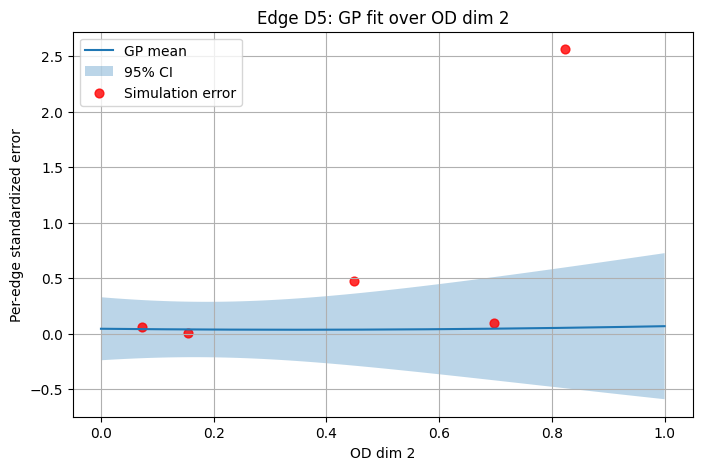

In [107]:
import torch
import matplotlib.pyplot as plt

# ---- Choose which edge to visualize ----
edge_to_plot = "D5"    # <-- put "L15" instead to visualize L15
# edge_to_plot = "L15"

# Find index of this edge
edge_idx = edge_ids.index(edge_to_plot)

# Extract the GP model for this edge
gp = model_list_gp_errors.models[edge_idx]
gp.eval()

# ---- Choose which OD dimension to visualize ----
dim_to_plot = 2  # 0, 1, 2, or 3
dim_names = [f"OD dim {i}" for i in range(train_X.shape[1])]

# Make a 1D grid for plotting
x_plot = torch.linspace(0, 1, 200).unsqueeze(-1)

# Create full input matrix (fix all other dims at their mean)
X_mean = train_X.mean(dim=0).unsqueeze(0)
X_plot = X_mean.repeat(200, 1)
X_plot[:, dim_to_plot] = x_plot.squeeze()

# Posterior predictions
posterior = gp.posterior(X_plot)
mean = posterior.mean.detach().numpy()
lower, upper = posterior.mvn.confidence_region()

# ---- Prepare raw data for this edge ----
y_raw = train_Y_errors[:, edge_idx].detach().numpy()
x_raw = train_X[:, dim_to_plot].detach().numpy()

# ---- Plot ----
plt.figure(figsize=(8, 5))

plt.plot(x_plot.numpy(), mean, label="GP mean")
plt.fill_between(
    x_plot.squeeze().numpy(),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.3,
    label="95% CI"
)

# Raw data points
plt.scatter(
    x_raw, y_raw,
    color='red',
    s=40,
    alpha=0.8,
    label="Simulation error"
)

plt.title(f"Edge {edge_to_plot}: GP fit over {dim_names[dim_to_plot]}")
plt.xlabel(dim_names[dim_to_plot])
plt.ylabel("Per-edge standardized error")
plt.legend()
plt.grid(True)
plt.show()

the plot shows how the D5 error changes when ONLY that OD variable changes.


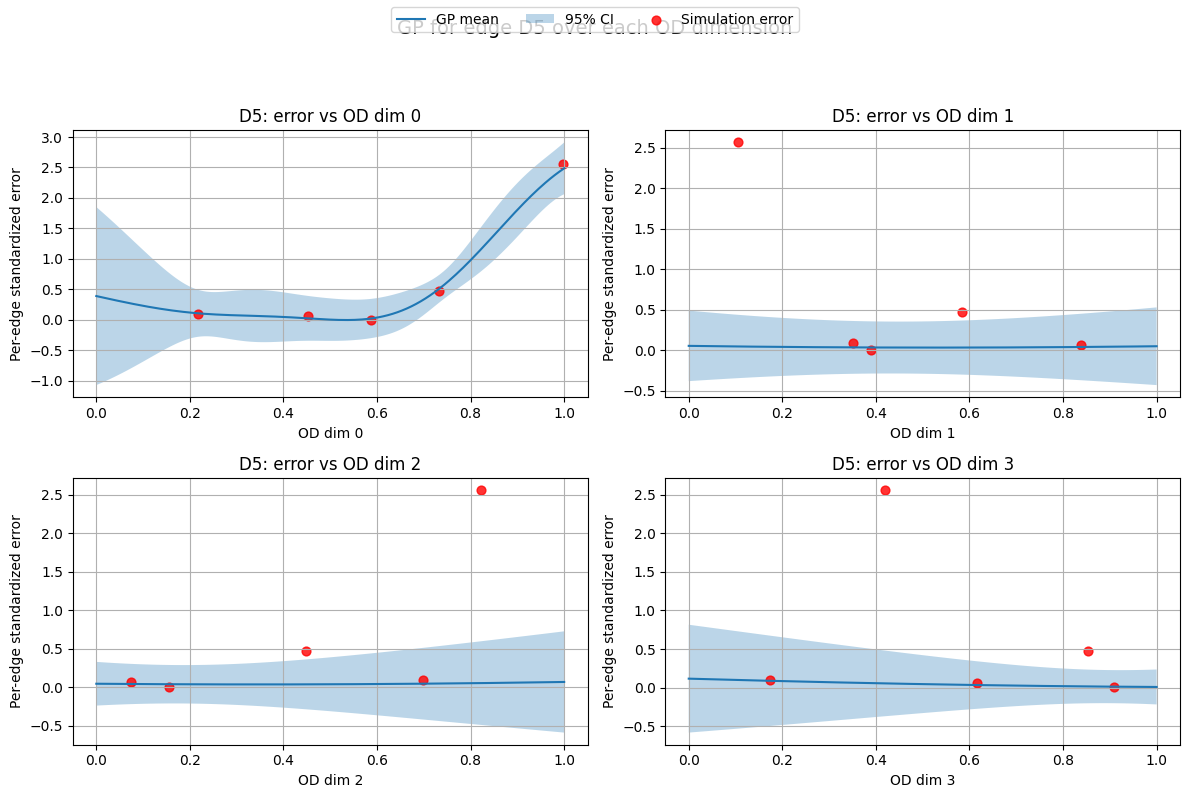

In [108]:
import torch
import matplotlib.pyplot as plt

# --------- Choose edge to visualize ----------
edge_to_plot = "D5"   # change to "L15", "D7", etc. if you want
edge_idx = edge_ids.index(edge_to_plot)

gp = model_list_gp_errors.models[edge_idx]
gp.eval()

n_dims = train_X.shape[1]
dim_labels = [f"OD dim {i}" for i in range(n_dims)]  # or replace with real OD names if you have them

X_mean = train_X.mean(dim=0).unsqueeze(0)  # (1, d)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for dim_to_plot in range(n_dims):
    # 1D grid for this dimension
    x_plot = torch.linspace(0, 1, 200).unsqueeze(-1)  # (200, 1)

    # Build full X_plot: all dims = mean, except this one
    X_plot = X_mean.repeat(200, 1)
    X_plot[:, dim_to_plot] = x_plot.squeeze()

    posterior = gp.posterior(X_plot)
    mean = posterior.mean.detach().numpy()
    lower, upper = posterior.mvn.confidence_region()

    # Raw data along this dim
    x_raw = train_X[:, dim_to_plot].detach().numpy()
    y_raw = train_Y_errors[:, edge_idx].detach().numpy()

    ax = axs[dim_to_plot]
    ax.plot(x_plot.numpy(), mean, label="GP mean")
    ax.fill_between(
        x_plot.squeeze().numpy(),
        lower.detach().numpy(),
        upper.detach().numpy(),
        alpha=0.3,
        label="95% CI"
    )
    ax.scatter(x_raw, y_raw, color="red", s=40, alpha=0.8, label="Simulation error")

    ax.set_title(f"{edge_to_plot}: error vs {dim_labels[dim_to_plot]}")
    ax.set_xlabel(dim_labels[dim_to_plot])
    ax.set_ylabel("Per-edge standardized error")
    ax.grid(True)

# One legend for all
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
fig.suptitle(f"GP for edge {edge_to_plot} over each OD dimension", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [109]:
print(train_X)

tensor([[0.9975, 0.1044, 0.8230, 0.4194],
        [0.4527, 0.8381, 0.0733, 0.6162],
        [0.2182, 0.3502, 0.6979, 0.1740],
        [0.7320, 0.5843, 0.4483, 0.8532],
        [0.5862, 0.3903, 0.1549, 0.9096]], dtype=torch.float64)


In [110]:
# Find index of D5
idx_D5 = edge_ids.index("D5")

# Extract squared relative errors for D5
errors_D5 = train_Y_errors[:, idx_D5]

print("Per-sample squared relative errors for D5:\n")
for i, e in enumerate(errors_D5):
    print(f"Sample {i}: {float(e):.6f}")

Per-sample squared relative errors for D5:

Sample 0: 2.562286
Sample 1: 0.062143
Sample 2: 0.095216
Sample 3: 0.470204
Sample 4: 0.003431


In [111]:
print(train_Y_errors)

tensor([[1.4496e+00, 1.4482e-01, 2.5623e+00, 6.3216e-02, 6.3216e-02, 1.4496e+00,
         1.4482e-01, 8.9401e+00, 4.5938e-03, 2.5623e+00, 1.4496e+00, 1.4482e-01,
         2.5623e+00, 6.3216e-02],
        [2.4996e+00, 5.4704e-02, 6.2143e-02, 1.1618e+00, 1.1618e+00, 2.4996e+00,
         5.4704e-02, 6.5610e-01, 1.3690e-01, 6.2143e-02, 2.4996e+00, 5.4704e-02,
         6.2143e-02, 1.1618e+00],
        [1.8496e-02, 9.6790e-04, 9.5216e-02, 6.3216e-02, 6.3216e-02, 1.8496e-02,
         9.6790e-04, 1.6384e-02, 3.7618e-01, 9.5216e-02, 1.8496e-02, 9.6790e-04,
         9.5216e-02, 6.3216e-02],
        [2.6667e+00, 1.9902e-01, 4.7020e-01, 1.1115e+00, 1.1115e+00, 2.6667e+00,
         1.9902e-01, 3.7172e+00, 8.0401e-01, 4.7020e-01, 2.6667e+00, 1.9902e-01,
         4.7020e-01, 1.1115e+00],
        [9.0630e-01, 3.3408e-02, 3.4306e-03, 7.3347e-01, 7.3347e-01, 9.0630e-01,
         3.3408e-02, 1.8063e+00, 1.0427e+00, 3.4306e-03, 9.0630e-01, 3.3408e-02,
         3.4306e-03, 7.3347e-01]], dtype=torch.float64

In [112]:
print("Learned mean:", gp_model.outcome_transform.means)
print("Learned std:", gp_model.outcome_transform.stdvs)

Learned mean: tensor([[0.6266]], dtype=torch.float64)
Learned std: tensor([[0.5403]], dtype=torch.float64)


In [113]:
# Print learned mean/std for all 14 independent GPs
print("=== Learned Standardization Stats for Each Independent GP ===")

for i, gp in enumerate(model_list_gp_errors.models):
    print(f"\nGP {i+1} — Edge {edge_ids[i]}")
    print("  Learned mean:", gp.outcome_transform.means.detach().cpu().numpy())
    print("  Learned std :", gp.outcome_transform.stdvs.detach().cpu().numpy())

=== Learned Standardization Stats for Each Independent GP ===

GP 1 — Edge D2
  Learned mean: [[1.5081332]]
  Learned std : [[1.10790594]]

GP 2 — Edge D4
  Learned mean: [[0.08658346]]
  Learned std : [[0.08247219]]

GP 3 — Edge D5
  Learned mean: [[0.63865612]]
  Learned std : [[1.09086366]]

GP 4 — Edge D7
  Learned mean: [[0.62663939]]
  Learned std : [[0.54031997]]

GP 5 — Edge L10
  Learned mean: [[0.62663939]]
  Learned std : [[0.54031997]]

GP 6 — Edge L12
  Learned mean: [[1.5081332]]
  Learned std : [[1.10790594]]

GP 7 — Edge L14
  Learned mean: [[0.08658346]]
  Learned std : [[0.08247219]]

GP 8 — Edge L15
  Learned mean: [[3.0272208]]
  Learned std : [[3.59221733]]

GP 9 — Edge L16
  Learned mean: [[0.47287012]]
  Learned std : [[0.4404066]]

GP 10 — Edge L18
  Learned mean: [[0.63865612]]
  Learned std : [[1.09086366]]

GP 11 — Edge L2
  Learned mean: [[1.5081332]]
  Learned std : [[1.10790594]]

GP 12 — Edge L4
  Learned mean: [[0.08658346]]
  Learned std : [[0.08247219]

# computing aggregated nrmse for using it in the acquisition function 

In [114]:
#creating linear aggregation model from the trained GPs

import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import make_linear_aggregation_model_from_error_gps

#computin gweight proportional to gt edge counts

observed_flows = gt_edge_data.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values

print(f"Total network flow: {observed_flows.sum():.0f} vehicles")


aggregated_gp_model = make_linear_aggregation_model_from_error_gps(
    model_list_gp_errors=model_list_gp_errors,
    weights=None, 
    ground_truth_flows= None 
)

print("Linear aggregation model created")
print(f"  Number of GPs: {len(aggregated_gp_model.models)}")
print(f"  Weights: {aggregated_gp_model.w}")
print(f"  Aggregation: S(x) = sum_l [w_l * e_l(x)]")

Total network flow: 18200 vehicles
Using uniform weights (1/14 each)
Linear aggregation model created
  Number of GPs: 14
  Weights: tensor([0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714])
  Aggregation: S(x) = sum_l [w_l * e_l(x)]


In [115]:
# Use the SAME weights as in the aggregated GP
w = aggregated_gp_model.w.to(device=train_Y_errors.device, dtype=train_Y_errors.dtype) 

# S_obs(x_i) = sum_l w_l * e_l(x_i)
S_obs_train = (train_Y_errors * w).sum(dim=1)    

best_S = S_obs_train.min().item()
best_idx = S_obs_train.argmin()

best_od = unnormalize(train_X[best_idx:best_idx+1], bounds).squeeze().cpu().numpy()

print(f"Best observed S(x): {best_S:.6f}")
print(f"\nBest training OD:")
for i, val in enumerate(best_od):
    print(f"  OD {i}: {val:.0f}")


Best observed S(x): 0.066161

Best training OD:
  OD 0: 436
  OD 1: 700
  OD 2: 1396
  OD 3: 348


S(x) = Σ_l w_l × e_l(x)

where:
- e_l(x) = (predicted_l(x) - observed_l)² / observed_l²  ← Squared relative error for edge l
- w_l = flow_l / Σ_l flow_l  ← Flow-proportional weight for edge l
- L = 14 edges in your network

In words:
S(x) = "Flow-weighted average of squared relative errors across all edges"

In [116]:
with torch.no_grad():
    post_train = aggregated_gp_model.posterior(train_X)  
    S_train_std = post_train.mean.reshape(-1)   # ✔ works even if tensor isn't contiguous
    best_f_for_ei = S_train_std.min()

In [117]:
from botorch.acquisition import ExpectedImprovement

with torch.no_grad():
    post_train = aggregated_gp_model.posterior(train_X)  
    S_train_std = post_train.mean.reshape(-1)   # ✔ works even if tensor isn't contiguous
    best_f_for_ei = S_train_std.min()

# 2. EI in standardized space
EI = ExpectedImprovement(
    model=aggregated_gp_model,
    best_f=best_f_for_ei,
    maximize=False
)

# 3. Optimize
d = train_X.shape[1]
acq_bounds = torch.stack([
    torch.zeros(d, device=device, dtype=dtype),
    torch.ones(d, device=device, dtype=dtype),
])

candidates, acq_val = optimize_acqf(
    EI,
    bounds=acq_bounds,
    q=1,
    num_restarts=20,
    raw_samples=512,
    #options={"batch_limit": 5, "maxiter": 200},
)

X_next_norm = candidates.detach()
X_next_real = unnormalize(X_next_norm, bounds)



/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [118]:
# EVALUATE PREDICTION AT NEW POINT
with torch.no_grad():
    post_next = aggregated_gp_model.posterior(X_next_norm)
    pred_S_mean_tensor = post_next.mean
    pred_S_var_tensor = post_next.variance
    
    if pred_S_mean_tensor.dim() > 0:
        pred_S_mean = pred_S_mean_tensor.squeeze().item()
    else:
        pred_S_mean = pred_S_mean_tensor.item()
    
    if pred_S_var_tensor.dim() > 0:
        pred_S_var = pred_S_var_tensor.squeeze().item()
    else:
        pred_S_var = pred_S_var_tensor.item()
    
    pred_S_std = np.sqrt(pred_S_var)
    #pred_RMSRE = np.sqrt(pred_S_mean)

next_od = X_next_real.squeeze().cpu().numpy()

print(f"Next OD candidate (normalized):")
print(f"  {X_next_norm.squeeze().cpu().numpy()}")
print(f"\nNext OD candidate (original scale):")
for i in range(len(next_od)):
    print(f"  OD {i}: {next_od[i]:8.0f}")


print(f"\nPredicted performance:")
print(f"  S(x):       {pred_S_mean:.6f} ± {pred_S_std:.6f}")
#print(f"  NRMSE:      {pred_RMSRE:.6f}")

print(f"\nBest observed (training):")
print(f"  S(x):       {best_S:.6f}")
#print(f"  NRMSE:      {np.sqrt(best_S):.6f}")

print(f"\nExpected improvement:")
improvement = max(0, best_S - pred_S_mean)
print(f"  ΔS(x):      {improvement:.6f}")
print(f"  EI value:   {acq_val.item():.6f}")

if pred_S_mean < best_S:
    print(f"\n GP predicts this will be better than best training sample!")
    print(f"   Expected improvement: {(best_S - pred_S_mean):.10f}")
else:
    print(f"\n GP predicts this might not be better (exploring uncertain region)")


Next OD candidate (normalized):
  [0.07457634 0.31946012 0.69216642 0.29188492]

Next OD candidate (original scale):
  OD 0:      149
  OD 1:      639
  OD 2:     1384
  OD 3:      584

Predicted performance:
  S(x):       0.116642 ± 0.107149

Best observed (training):
  S(x):       0.066161

Expected improvement:
  ΔS(x):      0.000000
  EI value:   0.022160

 GP predicts this might not be better (exploring uncertain region)


# addidn the complete BO LOOP 

In [119]:
import importlib
import helpers_od_calibration

importlib.reload(helpers_od_calibration)

from helpers_od_calibration import (
    initialize_independent_gp_models_with_modellist,
    BayesianOptimizationLoop,
    run_multiple_bo_restarts,
    #visualize_bo_results,
    #visualize_multiple_restarts,
    #save_bo_results_to_csv,
    plot_flow_coverage_per_edge,
    plot_best_iteration_like_prof,
    plot_iteration_like_prof,
    plot_all_iterations_like_prof,
    plot_od_comparison_per_iteration,
)


#continuing from the best found
bo_loop = BayesianOptimizationLoop(
    config=config,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    routes_df=routes_df,
    base_path=base_path,
    bounds=bounds,
    device=device,
    dtype=dtype,
)


BO Framework initialized
  Edges: 14
  OD dimension: 4


In [120]:
from helpers_od_calibration import plot_flow_coverage_per_edge

results = bo_loop.run_bo_loop(
    train_X_init=train_X,         
    train_Y_errors_init=train_Y_errors,
    n_iterations=10,             
)



STARTING BAYESIAN OPTIMIZATION LOOP

Initial training data: 5 samples
Initial best S (raw): 0.066161 (NRMSE: 0.257217)

BO ITERATION 1/10

Step 1: Update GP models
  Refitting GPs with 5 samples...
Using custom weights

Step 2: Optimize acquisition function
  Current best S (raw): 0.066161


/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.022160
  GP predicts S_std: 0.116642 ± 0.107149

Step 3: Run SUMO simulation
  OD (real): [ 149.15230288  638.92060627 1384.33200037  583.7707843 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2756.1756938144017
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.23
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.055431
  GP predicts S_std: 0.011944 ± 0.032835

Step 3: Run SUMO simulation
  OD (real): [ 343.33956739  650.25480763 1419.84279615    0.        ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2413.4371711622575
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.05
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.017473
  GP predicts S_std: 0.049788 ± 0.013906

Step 3: Run SUMO simulation
  OD (real): [ 531.00788721  672.01892757 1395.78344365  451.53499267]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3050.345251107108
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.67
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.006751
  GP predicts S_std: 0.090012 ± 0.036867

Step 3: Run SUMO simulation
  OD (real): [ 348.01464186  667.54085323 1395.4249237   927.01891006]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3337.9993288476703
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.03
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.040129
  GP predicts S_std: 0.029843 ± 0.018584

Step 3: Run SUMO simulation
  OD (real): [ 180.89937741  755.98090046 1394.51791318  908.95944772]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3240.357638773269
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.01
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.043349
  GP predicts S_std: 0.028649 ± 0.029025

Step 3: Run SUMO simulation
  OD (real): [ 334.1172622   682.9878812  1261.45600061  408.98416405]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2687.5453080588168
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.55
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.030007
  GP predicts S_std: 0.045009 ± 0.012496

Step 3: Run SUMO simulation
  OD (real): [ 332.17983827  683.0419911  1495.89498935  415.63269074]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2926.749509468314
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.90
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.083908
  GP predicts S_std: -0.012705 ± 0.043829

Step 3: Run SUMO simulation
  OD (real): [414.00307272 634.53613237 439.92339467 836.47444794]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2324.9370476956674
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.10
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbe

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.023055
  GP predicts S_std: 0.015445 ± 0.011671

Step 3: Run SUMO simulation
  OD (real): [ 421.21112855  614.1572826  1005.7526354   834.39383856]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2875.5148851039557
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.76
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.030867
  GP predicts S_std: -0.005202 ± 0.053508

Step 3: Run SUMO simulation
  OD (real): [  0.         728.55058418 870.47455917 839.50497446]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2438.530117812525
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.79
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

# result analysis 

Best BO iteration index: 13


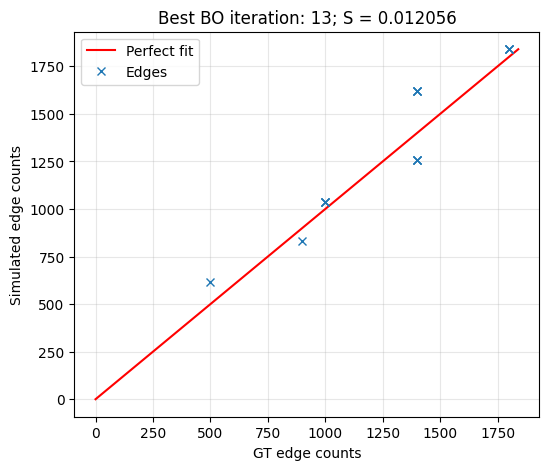

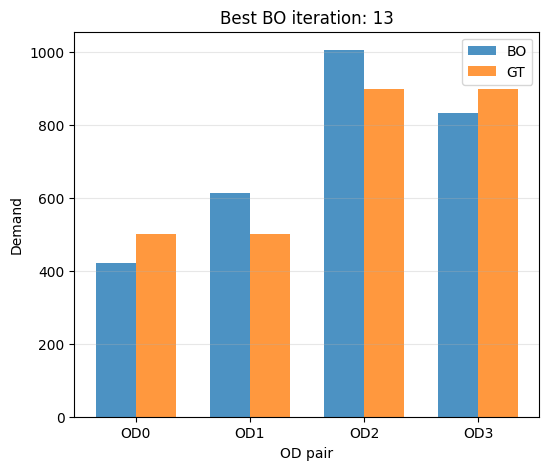

In [121]:
plot_best_iteration_like_prof(
    results=results,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs",
)

In [122]:
gt_edge_data["edge_id"].unique()

array(['D4', 'L14', 'L4', 'D5', 'D7', 'L10', 'L18', 'L5', 'L7', 'D2',
       'L12', 'L2', 'L16', 'L15'], dtype=object)

Plotting 15 evaluations (0..14)
[plot] No edge stats for eval_idx 0 – skipping.
[plot] No edge stats for eval_idx 1 – skipping.
[plot] No edge stats for eval_idx 2 – skipping.
[plot] No edge stats for eval_idx 3 – skipping.
[plot] No edge stats for eval_idx 4 – skipping.
Saved output/quickstart_bo_vanilla/figs/bo_eval_05_prof_style.png


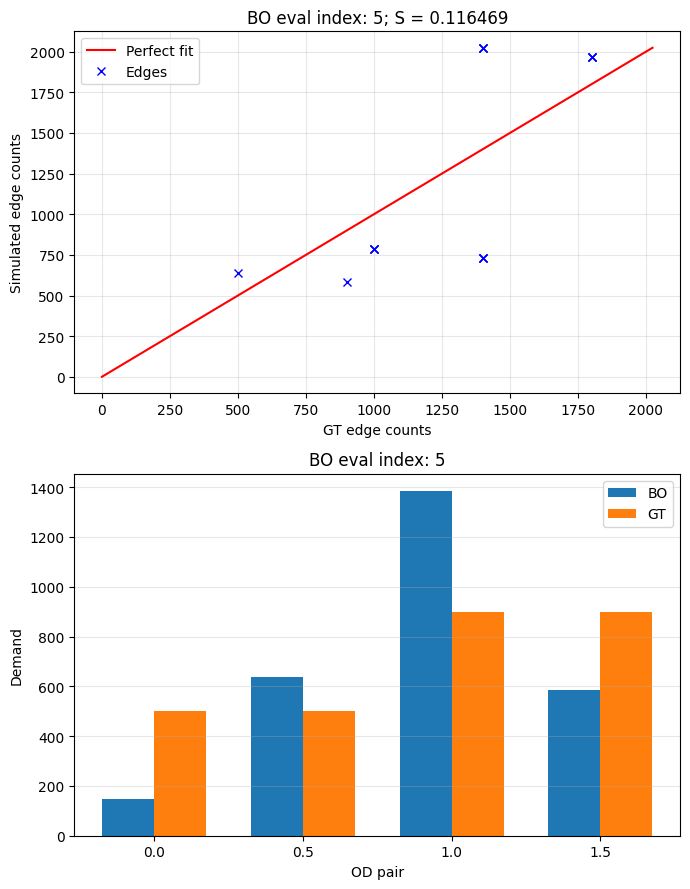

Saved output/quickstart_bo_vanilla/figs/bo_eval_06_prof_style.png


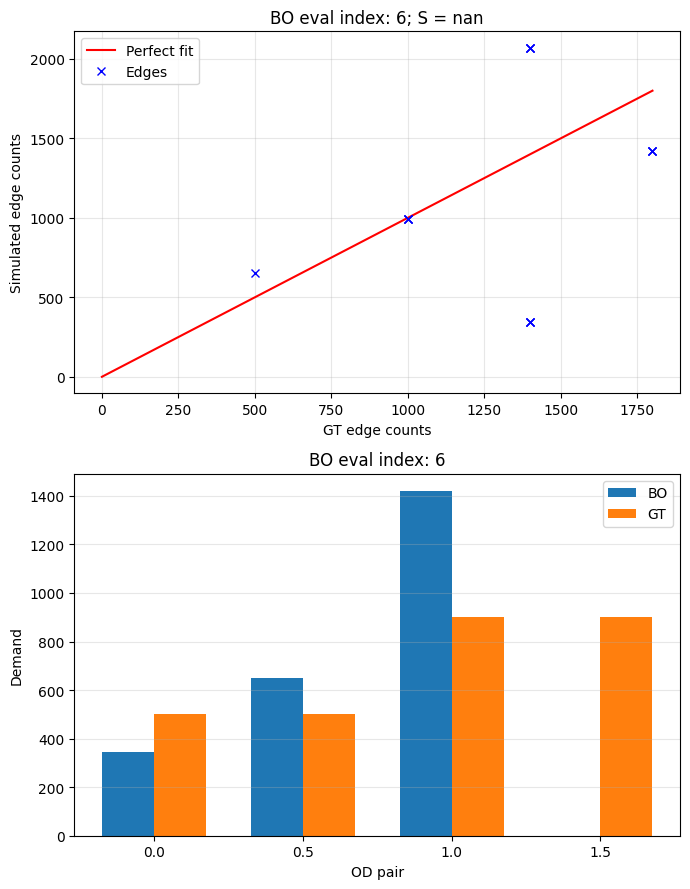

Saved output/quickstart_bo_vanilla/figs/bo_eval_07_prof_style.png


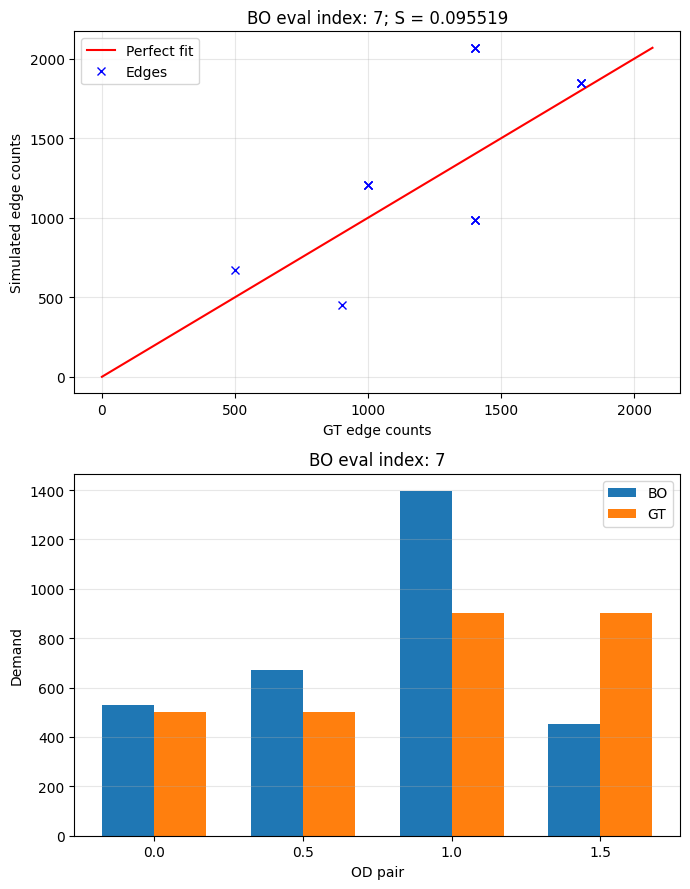

Saved output/quickstart_bo_vanilla/figs/bo_eval_08_prof_style.png


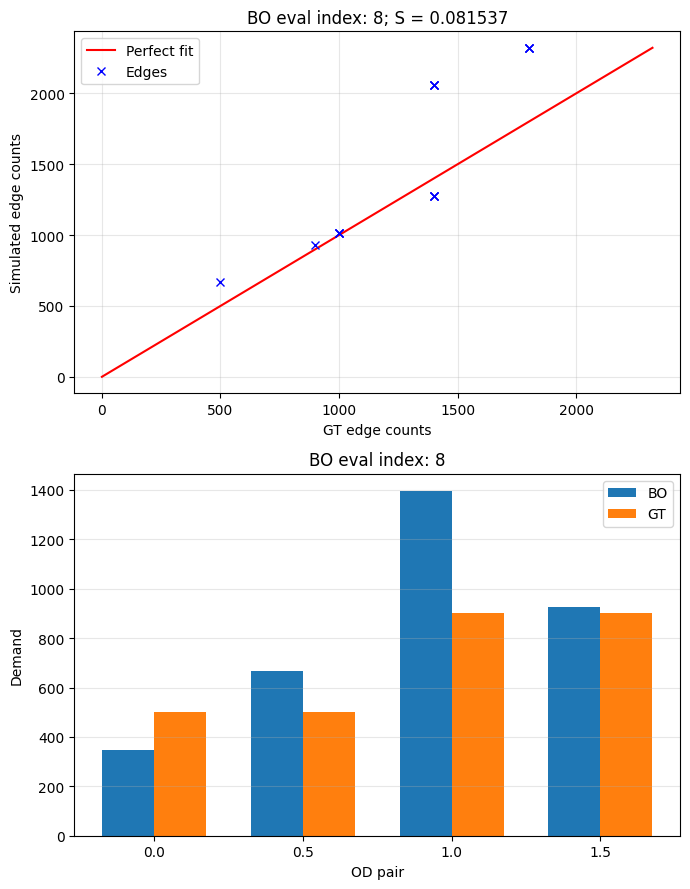

Saved output/quickstart_bo_vanilla/figs/bo_eval_09_prof_style.png


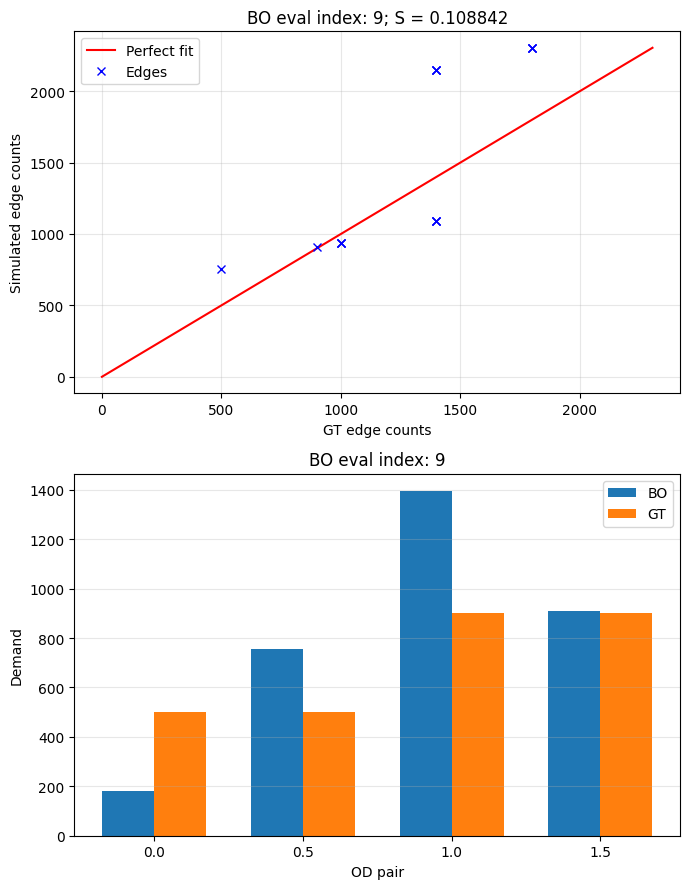

Saved output/quickstart_bo_vanilla/figs/bo_eval_10_prof_style.png


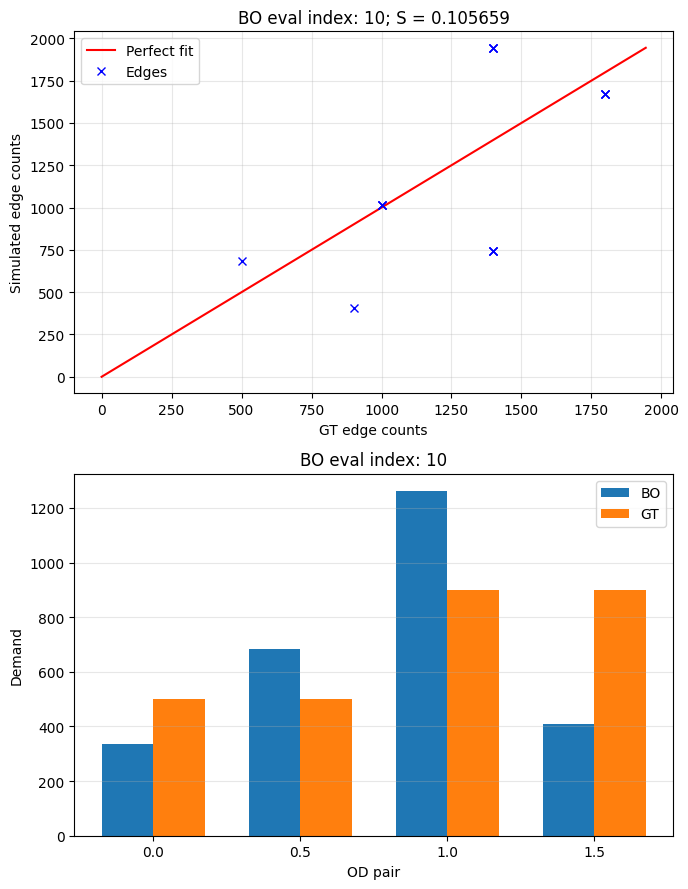

Saved output/quickstart_bo_vanilla/figs/bo_eval_11_prof_style.png


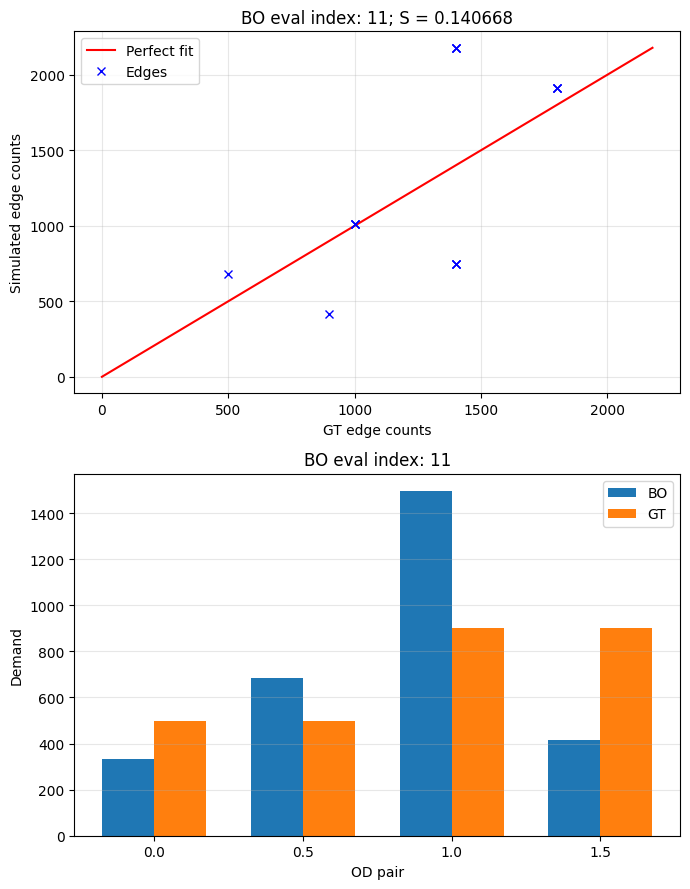

Saved output/quickstart_bo_vanilla/figs/bo_eval_12_prof_style.png


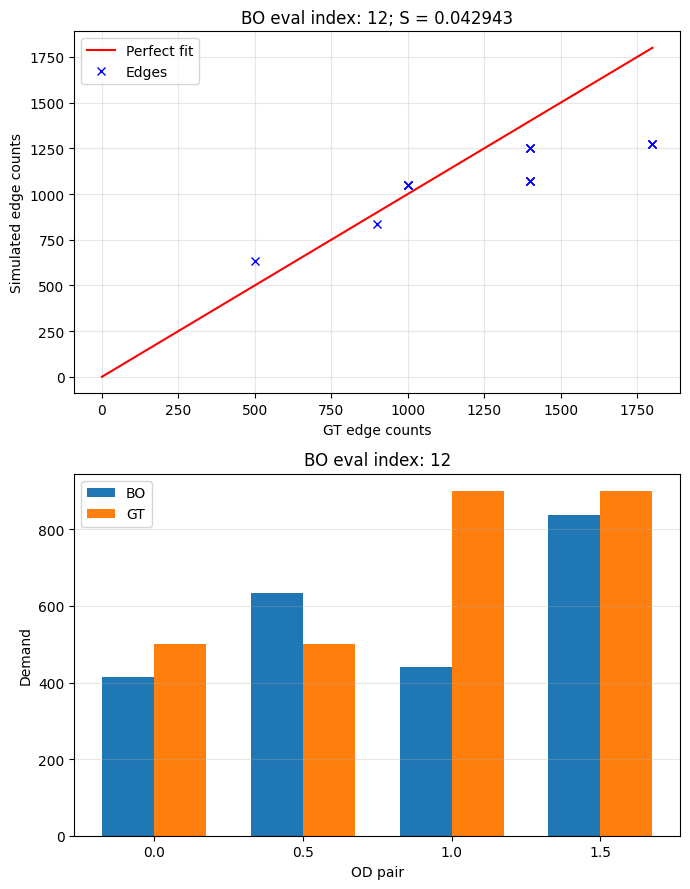

Saved output/quickstart_bo_vanilla/figs/bo_eval_13_prof_style.png


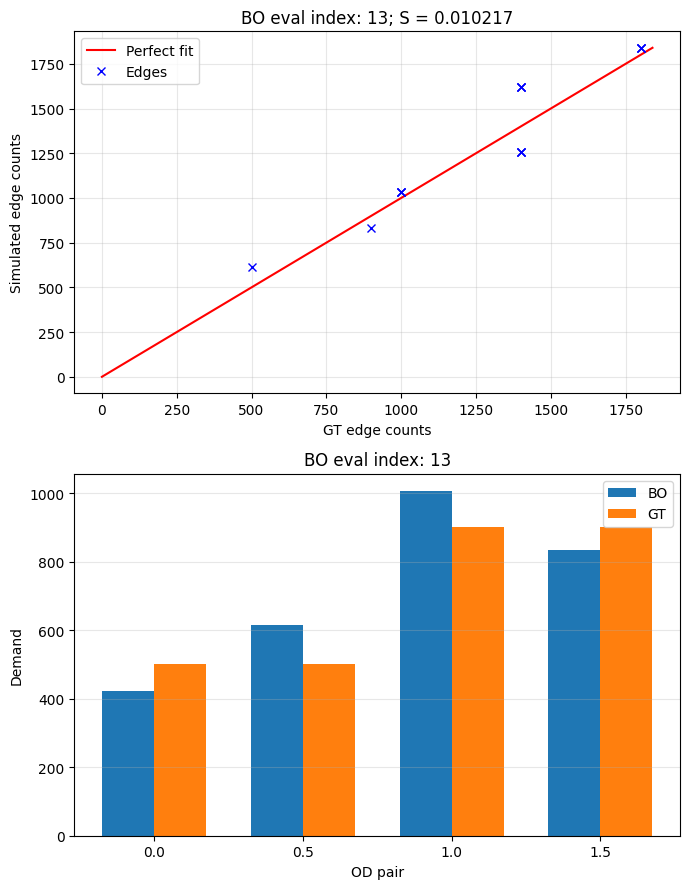

Saved output/quickstart_bo_vanilla/figs/bo_eval_14_prof_style.png


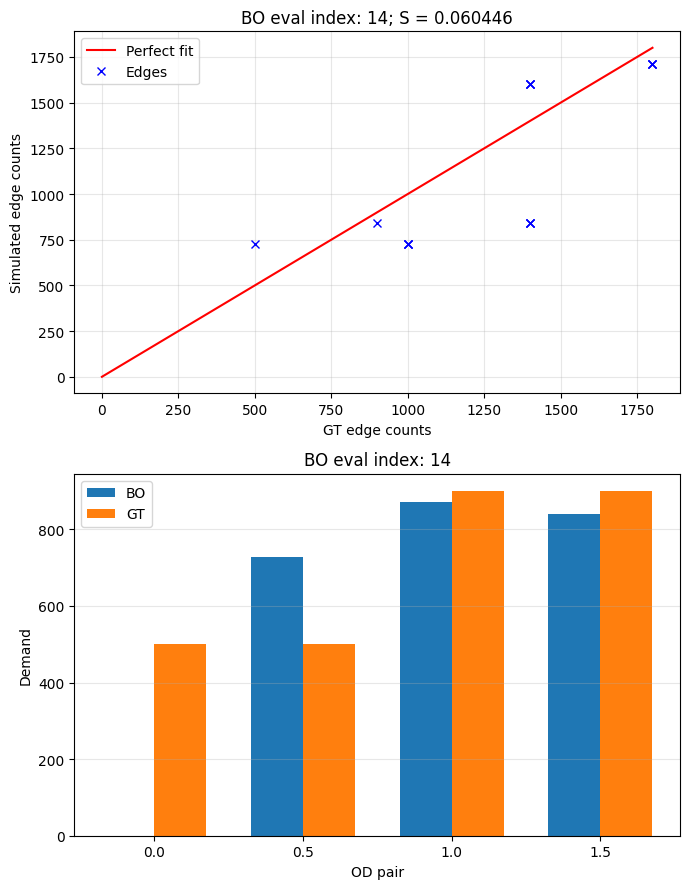

In [123]:
plot_all_iterations_like_prof(
    results=results,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs",
)


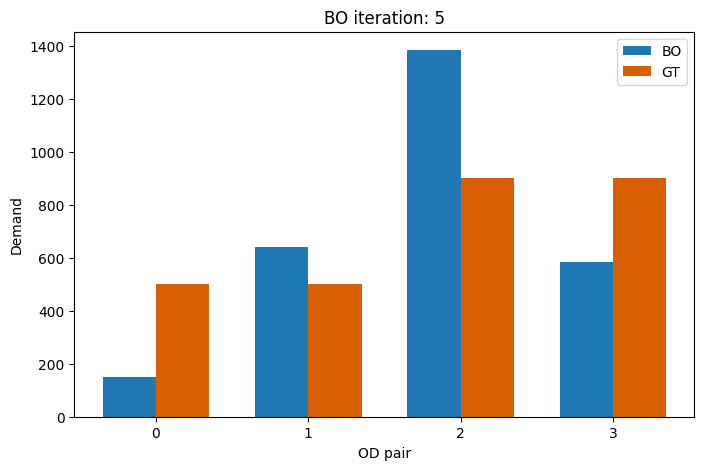

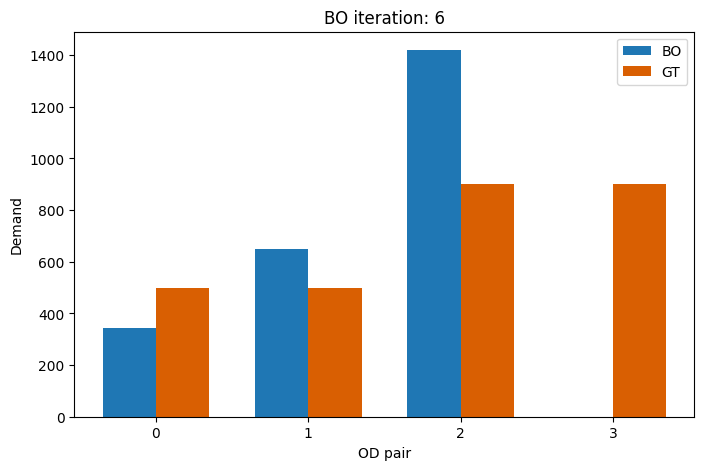

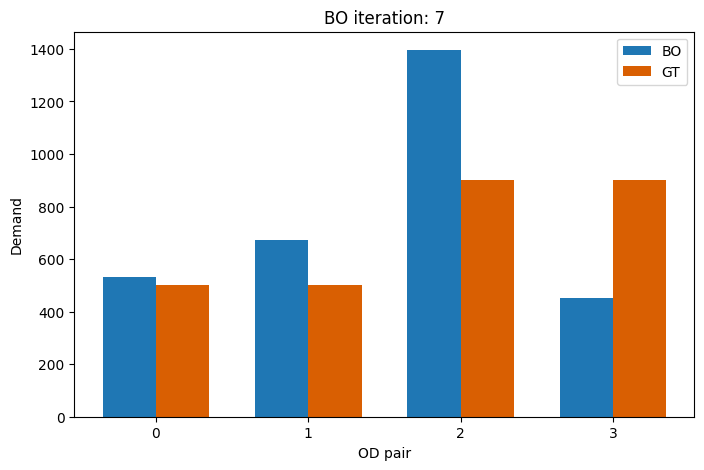

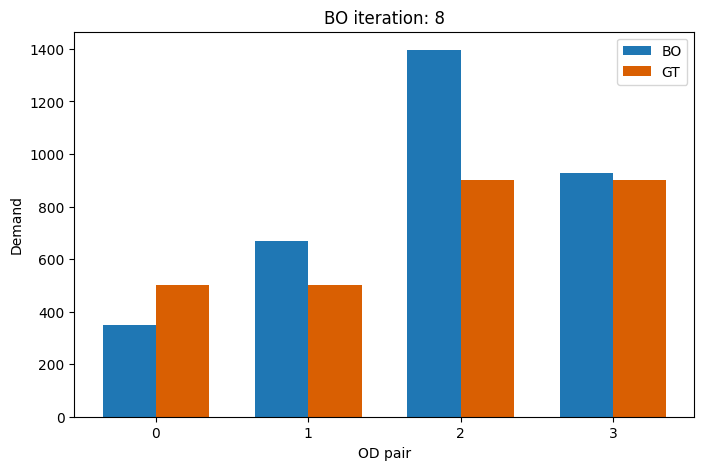

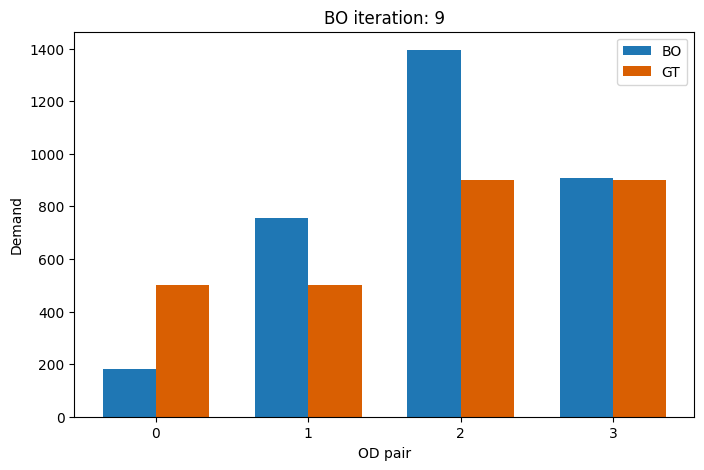

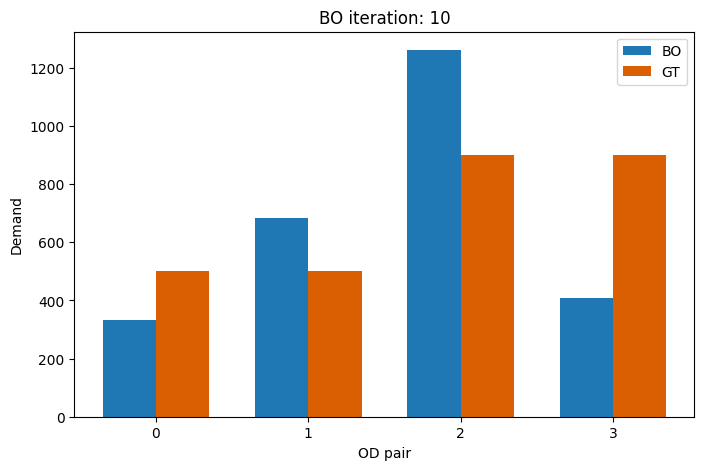

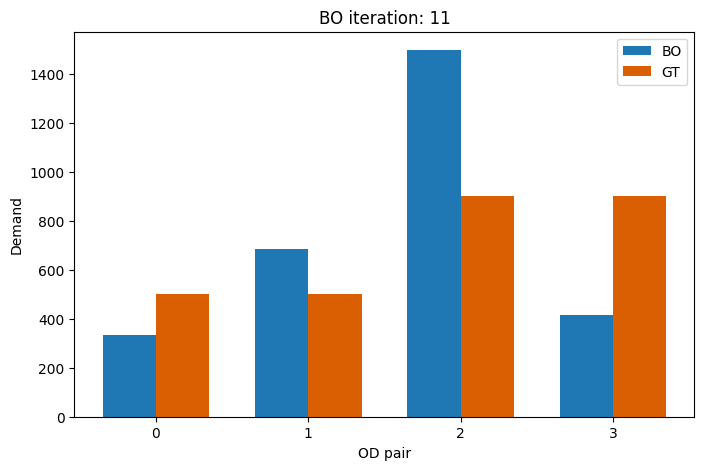

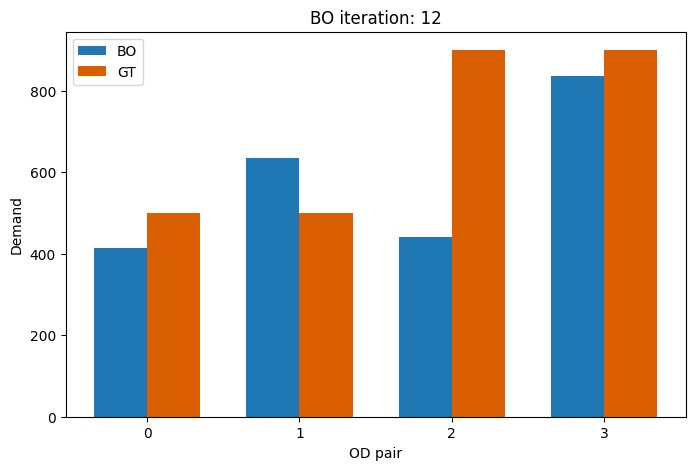

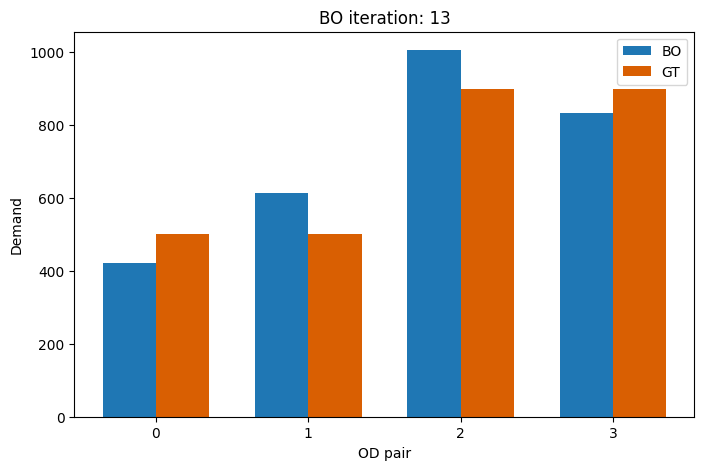

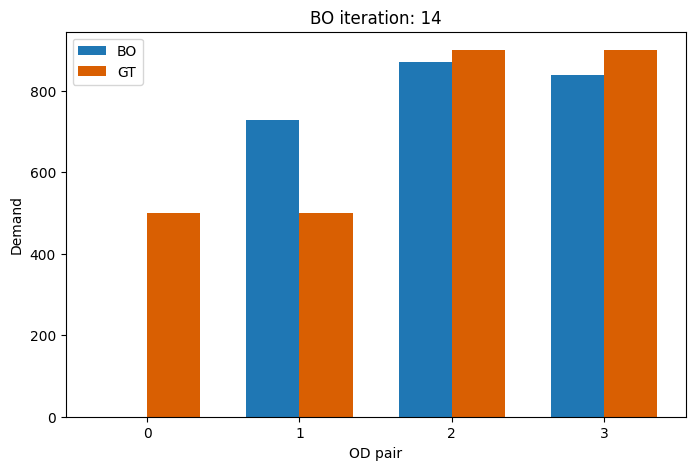

In [124]:
plot_od_comparison_per_iteration(
    results=results,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs"
)

Saved plot to output/quickstart_bo_vanilla/figs/convergence_bo_only.png


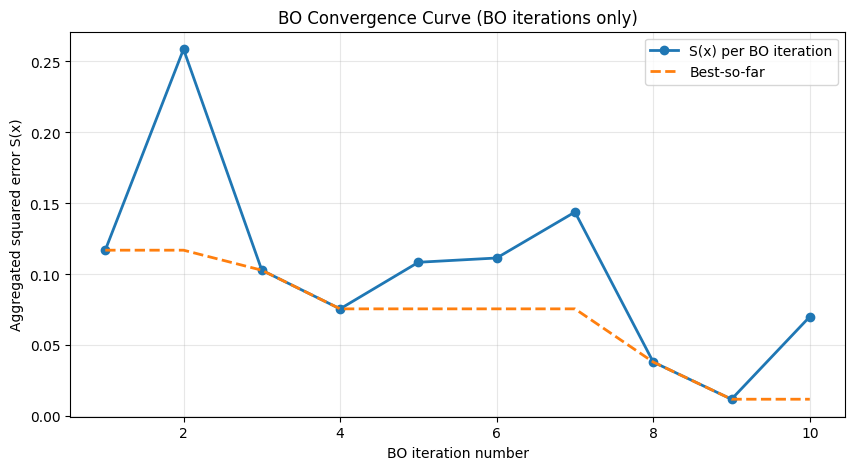

In [125]:
def plot_convergence_bo_only(results, save_path=None):
    """
    Plot convergence curve showing ONLY the BO iterations.
    Initial samples are removed.
    """

    S_all = results.all_S.cpu().numpy()
    start = results.iteration_start        # number of initial samples

    # Extract only BO iterations
    S_bo = S_all[start:]                   # shape (n_bo_iterations,)
    iters_bo = np.arange(1, len(S_bo) + 1)

    # Best-so-far only within BO phase
    best_so_far = np.minimum.accumulate(S_bo)

    plt.figure(figsize=(10, 5))
    plt.plot(iters_bo, S_bo, marker="o", linewidth=2,
             label="S(x) per BO iteration")
    plt.plot(iters_bo, best_so_far, "--", linewidth=2,
             label="Best-so-far")

    plt.xlabel("BO iteration number")
    plt.ylabel("Aggregated squared error S(x)")
    plt.title("BO Convergence Curve (BO iterations only)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to {save_path}")

    plt.show()



plot_convergence_bo_only(
    results,
    save_path=f"{config['simulation_run_path']}/figs/convergence_bo_only.png"
)

In [126]:
print("per_edge_errors:", per_edge_errors)
print("weights:", weights)
print("curr_loss S(x):", curr_loss)

per_edge_errors: [0.906304   0.03340772 0.00343061 0.7334699  0.7334699  0.906304
 0.03340772 1.806336   1.0426679  0.00343061 0.906304   0.03340772
 0.00343061 0.7334699 ]
weights: tensor([0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714], dtype=torch.float64)
curr_loss S(x): 0.5627743271424971


# BO WITH MULTIPLE RESTART

In [127]:
import importlib
import helpers_od_calibration
importlib.reload(helpers_od_calibration)

aggregated_results = run_multiple_bo_restarts(
    config=config,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    routes_df=routes_df,
    base_path=base_path,
    bounds=bounds,
    device=device,
    dtype=dtype,
    train_X_init=train_X,               
    train_Y_errors_init=train_Y_errors,
    n_restarts=5,
    n_bo_iterations=10
)


RUNNING 5 BO RESTARTS

######################################################################
RESTART 1/5
######################################################################
BO Framework initialized
  Edges: 14
  OD dimension: 4

Generating 5 initial samples...
  Initial sample 1/5...   Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3751.9242763519287
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.87
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_0/sim_ --ignore-route-errors=

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.062185
  GP predicts S_std: 0.246721 ± 0.109830

Step 3: Run SUMO simulation
  OD (real): [ 282.60316242   27.17587191 1000.3431094  1001.09324056]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2311.2153842900166
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.47
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.021742
  GP predicts S_std: 0.221991 ± 0.092040

Step 3: Run SUMO simulation
  OD (real): [189.83749477  52.45561806 995.79944526 980.37848774]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2218.4710458313157
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.54
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamz

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.152685
  GP predicts S_std: 0.033882 ± 0.055273

Step 3: Run SUMO simulation
  OD (real): [ 293.29836453  466.46495821  966.52174433 1164.23414923]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2890.51921628742
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenha

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.008393
  GP predicts S_std: 0.019437 ± 0.009764

Step 3: Run SUMO simulation
  OD (real): [ 426.08970907  537.31227075 1006.44011247 1159.18213597]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3129.024228257572
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.35
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.002309
  GP predicts S_std: 0.020432 ± 0.004368

Step 3: Run SUMO simulation
  OD (real): [ 483.14076003  498.43384353  961.73290313 1140.46762399]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3083.775130681591
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.84
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000001
  GP predicts S_std: 0.077907 ± 0.016766

Step 3: Run SUMO simulation
  OD (real): [ 952.77136697  548.50397921  816.08280843 1103.25604189]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3420.614196501718
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.59
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.009243
  GP predicts S_std: 0.008126 ± 0.006638

Step 3: Run SUMO simulation
  OD (real): [ 439.73681488  521.78894912  678.64025042 1137.27552653]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2777.441540942579
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.87
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.001097
  GP predicts S_std: 0.011961 ± 0.000648

Step 3: Run SUMO simulation
  OD (real): [ 449.18288626  487.9091119   756.69724242 1134.54006822]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2828.329308805094
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.34
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000798
  GP predicts S_std: 0.014165 ± 0.003549

Step 3: Run SUMO simulation
  OD (real): [ 466.23773793  463.63866865  723.40019443 1157.16488802]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2810.4414890262474
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.87
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000000
  GP predicts S_std: 0.045563 ± 0.007132

Step 3: Run SUMO simulation
  OD (real): [ 568.36435758  561.55972369  289.10414502 1148.72048236]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2567.74870865047
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.48
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesb

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.121535
  GP predicts S_std: -0.008304 ± 0.134349

Step 3: Run SUMO simulation
  OD (real): [ 409.17297509  588.88279134  337.4991284  1207.63609258]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2543.1909874009893
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.75
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbe

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.024010
  GP predicts S_std: 0.030612 ± 0.040119

Step 3: Run SUMO simulation
  OD (real): [ 694.18254409  526.52130649  207.99994092 1258.18554113]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2686.8893326375032
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.71
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.041740
  GP predicts S_std: 0.015011 ± 0.060269

Step 3: Run SUMO simulation
  OD (real): [   0.          717.79723053  472.13107958 1041.78519845]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2231.7135085648356
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.79
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.029606
  GP predicts S_std: 0.015104 ± 0.010302

Step 3: Run SUMO simulation
  OD (real): [ 392.805546    592.0720512   498.83469593 1108.07252818]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2591.784821308789
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.003993
  GP predicts S_std: 0.030397 ± 0.020109

Step 3: Run SUMO simulation
  OD (real): [ 345.42407093  431.52307423  511.01394418 1155.98392741]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2443.9450167439436
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.005740
  GP predicts S_std: 0.015832 ± 0.007291

Step 3: Run SUMO simulation
  OD (real): [ 306.10848501  699.58400294  539.87525726 1162.55691899]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2708.1246642049027
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.36
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.004499
  GP predicts S_std: 0.016159 ± 0.003852

Step 3: Run SUMO simulation
  OD (real): [ 382.55425825  597.64537924  628.26254431 1109.32995716]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2717.792138968265
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.25
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.002966
  GP predicts S_std: 0.008357 ± 0.002448

Step 3: Run SUMO simulation
  OD (real): [ 400.15977939  557.3542309   758.92969783 1092.47753015]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2808.9212382664305
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.63
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.002570
  GP predicts S_std: 0.003999 ± 0.002164

Step 3: Run SUMO simulation
  OD (real): [ 384.09850266  541.3626095   818.02281836 1005.16275228]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2748.6466828047405
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.72
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000817
  GP predicts S_std: 0.006818 ± 0.005661

Step 3: Run SUMO simulation
  OD (real): [ 498.94754024  447.26555643 1002.38344902  942.19939645]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2890.7959421374494
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.10
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.291398
  GP predicts S_std: 0.007081 ± 0.170108

Step 3: Run SUMO simulation
  OD (real): [ 536.74977796  171.84319861  176.73876221 1533.17743558]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2418.509174361559
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.71
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.131869
  GP predicts S_std: 0.123030 ± 0.052367

Step 3: Run SUMO simulation
  OD (real): [ 588.91742577  451.65857492  160.92137085 1701.87044867]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2903.3678202019305
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.047084
  GP predicts S_std: 0.195112 ± 0.094661

Step 3: Run SUMO simulation
  OD (real): [ 495.3379575   577.63050849 1972.80647252 1530.05032193]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 4575.825260438321
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.22
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.100270
  GP predicts S_std: 0.113479 ± 0.060299

Step 3: Run SUMO simulation
  OD (real): [593.69397435 565.46555822 669.20357268 823.68638744]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2652.0494926911083
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamz

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.009186
  GP predicts S_std: 0.011109 ± 0.015389

Step 3: Run SUMO simulation
  OD (real): [523.12255293 577.13043636 775.92196679 944.83887754]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2821.0138336148693
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.71
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamz

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.005417
  GP predicts S_std: 0.004584 ± 0.012797

Step 3: Run SUMO simulation
  OD (real): [621.23532532 475.46762694 872.08419994 907.50631173]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2876.293463936282
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.48
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.002171
  GP predicts S_std: 0.002324 ± 0.001907

Step 3: Run SUMO simulation
  OD (real): [556.42161404 513.68960835 857.12309433 907.37894814]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2834.6132648561143
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.47
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.001617
  GP predicts S_std: 0.093072 ± 0.059569

Step 3: Run SUMO simulation
  OD (real): [   0.          585.49907724  782.78226612 1099.9026736 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2468.184016959178
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.74
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.001187
  GP predicts S_std: 0.001289 ± 0.002394

Step 3: Run SUMO simulation
  OD (real): [468.0779286  506.42414557 845.04530269 950.48068542]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2770.02806228257
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.47
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenha

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000484
  GP predicts S_std: 0.000463 ± 0.000903

Step 3: Run SUMO simulation
  OD (real): [494.79263982 499.34572731 903.35949496 914.59647169]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2812.094333783469
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.09
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.054543
  GP predicts S_std: 0.259822 ± 0.095769

Step 3: Run SUMO simulation
  OD (real): [ 337.5929688   478.52692008  248.43873484 1075.03921365]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2139.597837373186
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.02
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.022957
  GP predicts S_std: 0.059311 ± 0.034184

Step 3: Run SUMO simulation
  OD (real): [419.61751974 438.51028066 234.87925185 809.44959452]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 1902.4566467813963
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 298.97
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamz

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.035887
  GP predicts S_std: 0.040533 ± 0.029125

Step 3: Run SUMO simulation
  OD (real): [ 366.88544352  577.41575336  564.99944324 1102.24860004]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2611.549240158742
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.73
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.004580
  GP predicts S_std: 0.016041 ± 0.012821

Step 3: Run SUMO simulation
  OD (real): [364.09224727 663.66457262 567.92491764 966.52141228]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2562.203149814639
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.21
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.002071
  GP predicts S_std: 0.014154 ± 0.004145

Step 3: Run SUMO simulation
  OD (real): [ 380.41510286  612.01752869  521.53655154 1041.83134552]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2555.8005286042435
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.86
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.007144
  GP predicts S_std: 0.007797 ± 0.003025

Step 3: Run SUMO simulation
  OD (real): [ 381.7806048   595.72740375  684.52121995 1000.96908342]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2662.9983119148296
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.24
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000000
  GP predicts S_std: 0.070567 ± 0.015910

Step 3: Run SUMO simulation
  OD (real): [ 296.55849375  491.51123874 1105.63354753 1072.10151479]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2965.8047948032618
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.003314
  GP predicts S_std: 0.002811 ± 0.001547

Step 3: Run SUMO simulation
  OD (real): [374.02139641 551.56314432 830.59487745 995.36939832]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2751.5488165069355
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.10
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000000
  GP predicts S_std: 0.184435 ± 0.041004

Step 3: Run SUMO simulation
  OD (real): [ 631.51893765  121.88119441 1340.9635555   988.50674927]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3082.8704368323088
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.66
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ine

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.001707
  GP predicts S_std: 0.002455 ± 0.003665

Step 3: Run SUMO simulation
  OD (real): [464.18730461 478.30478086 913.58747559 918.02339088]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2774.102951945639
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.51
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.068949
  GP predicts S_std: 0.267793 ± 0.106606

Step 3: Run SUMO simulation
  OD (real): [ 481.09778949  537.56554039 2000.         1323.71248221]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 4342.375812102503
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.78
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.111960
  GP predicts S_std: 0.201544 ± 0.055077

Step 3: Run SUMO simulation
  OD (real): [ 561.61717073  546.70517716  555.26768913 1390.5211876 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3054.1112246174293
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.68
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.031629
  GP predicts S_std: 0.044961 ± 0.042910

Step 3: Run SUMO simulation
  OD (real): [ 507.74305676  615.67425291  632.03837166 1078.78075222]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2834.236433551512
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.76
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenh

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.011372
  GP predicts S_std: 0.018134 ± 0.030216

Step 3: Run SUMO simulation
  OD (real): [295.63312831 621.8561759  631.71817801 976.19095752]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2525.398439736681
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.007503
  GP predicts S_std: 0.008955 ± 0.013372

Step 3: Run SUMO simulation
  OD (real): [ 333.02448549  689.78391148  553.60741924 1110.55934405]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2686.97516026238
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.05
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenha

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.005734
  GP predicts S_std: 0.007188 ± 0.003494

Step 3: Run SUMO simulation
  OD (real): [ 381.71010753  621.41103734  713.64890813 1025.67677726]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2742.446830260519
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.27
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.001105
  GP predicts S_std: 0.007793 ± 0.004378

Step 3: Run SUMO simulation
  OD (real): [429.6626265  564.96341393 812.43574209 964.33762595]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2771.3994084667693
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.65
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000701
  GP predicts S_std: 0.002553 ± 0.002712

Step 3: Run SUMO simulation
  OD (real): [500.20492601 521.04755739 892.51990682 896.47083079]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2810.2432210115576
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.16
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000021
  GP predicts S_std: 0.255400 ± 0.081974

Step 3: Run SUMO simulation
  OD (real): [1161.0133585     0.         1508.40446114    0.        ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2669.417819636239
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.87
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/ines

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.000516
  GP predicts S_std: 0.000989 ± 0.002091

Step 3: Run SUMO simulation
  OD (real): [512.75738811 463.23553577 919.70650445 891.70872479]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2787.4081531128704
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.16
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesben


===== ACROSS-RESTART VARIABILITY =====

Restart 1: best S = 0.012685 (NRMSE = 0.1126)
Restart 2: best S = 0.002890 (NRMSE = 0.0538)
Restart 3: best S = 0.000057 (NRMSE = 0.0075)
Restart 4: best S = 0.000996 (NRMSE = 0.0316)
Restart 5: best S = 0.000249 (NRMSE = 0.0158)

--- Summary ---
Mean final loss      : 0.003375
Std dev final loss   : 0.004761
Best final loss       : 0.000057
All final losses      : [0.012684913472267214, 0.002889863513659432, 5.655217219162797e-05, 0.0009955509124284635, 0.0002487569376957132]

>>> BEST restart index = 2
Best OD vector: [494.79263982 499.34572731 903.35949496 914.59647169]


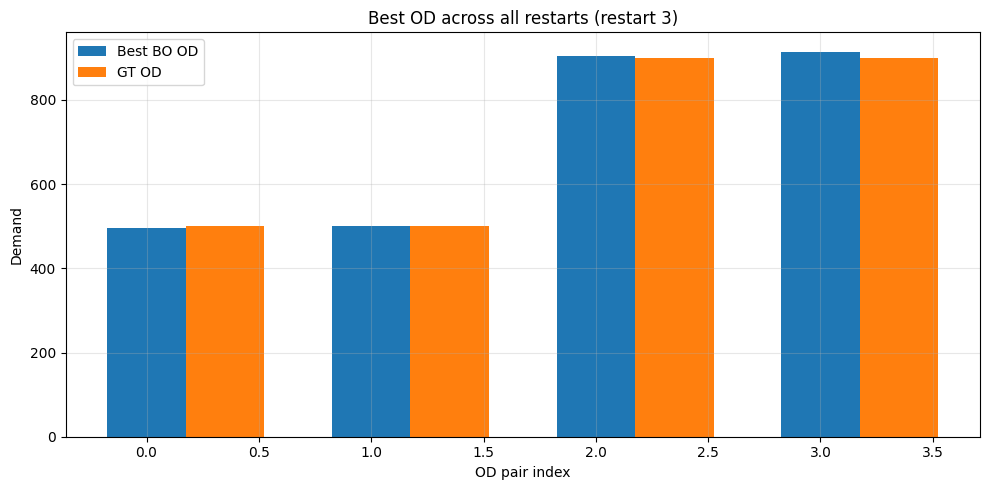

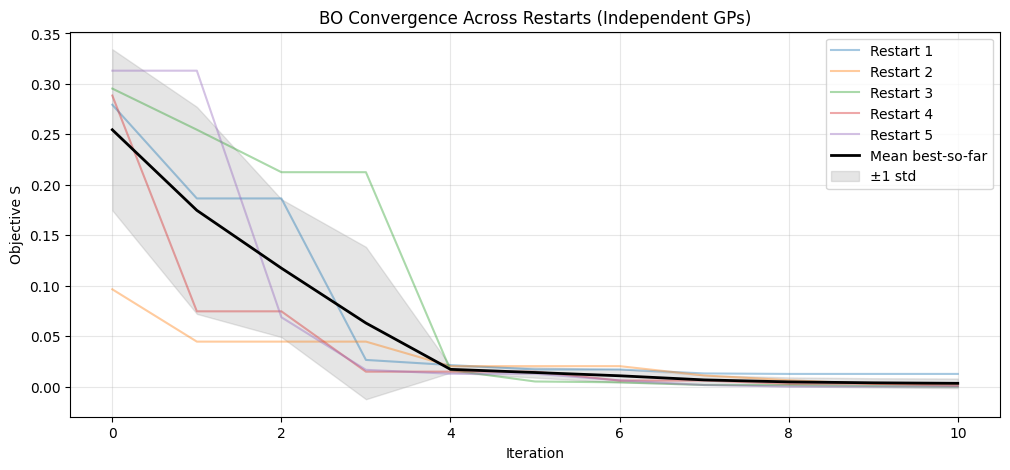

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# =========================================================
# === 1. ACROSS-RESTART VARIABILITY SUMMARY ===============
# =========================================================

all_results = aggregated_results["all_results"]
best_S_all = aggregated_results["best_S_all"]
mean_curve = aggregated_results["mean_curve"]
std_curve = aggregated_results["std_curve"]

print("\n===== ACROSS-RESTART VARIABILITY =====\n")
for i, s in enumerate(best_S_all):
    print(f"Restart {i+1}: best S = {s:.6f} (NRMSE = {np.sqrt(s):.4f})")

print("\n--- Summary ---")
print(f"Mean final loss      : {np.mean(best_S_all):.6f}")
print(f"Std dev final loss   : {np.std(best_S_all):.6f}")
print(f"Best final loss       : {np.min(best_S_all):.6f}")
print(f"All final losses      : {best_S_all}")


# =========================================================
# === 2. PLOT BEST-OF-RUN OD VS GT OD ====================
# =========================================================

overall_best_result = aggregated_results["overall_best_result"]
overall_idx = aggregated_results["overall_best_restart"]

print(f"\n>>> BEST restart index = {overall_idx}")

# Best XS and YS
best_X_norm = overall_best_result.best_X
best_X_real = unnormalize(best_X_norm.unsqueeze(0), bounds).squeeze().cpu().numpy()

print("Best OD vector:", best_X_real)

# ===== BAR PLOT =====
plt.figure(figsize=(10, 5))
idx = np.arange(len(best_X_real))
width = 0.35

plt.bar(idx, best_X_real, width, label="Best BO OD")
plt.bar(idx + width, gt_od_vals, width, label="GT OD")

plt.xlabel("OD pair index")
plt.ylabel("Demand")
plt.title(f"Best OD across all restarts (restart {overall_idx+1})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

fig_dir = Path(f"{config['simulation_run_path']}/figs_independent_gps")
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "best_OD_across_restarts_independentGP.png", dpi=300)

plt.show()



# === 3. PLOT CONVERGENCE CURVES FOR ALL RESTARTS =========


plt.figure(figsize=(12, 5))

# plot each restart
for i, r in enumerate(all_results):
    plt.plot(r.convergence_curve, alpha=0.4, label=f"Restart {i+1}")

# plot mean and std
plt.plot(mean_curve, color="black", linewidth=2, label="Mean best-so-far")

plt.fill_between(
    np.arange(len(mean_curve)),
    mean_curve - std_curve,
    mean_curve + std_curve,
    color="gray",
    alpha=0.2,
    label="±1 std",
)

plt.xlabel("Iteration")
plt.ylabel("Objective S")
plt.title("BO Convergence Across Restarts (Independent GPs)")
plt.legend()
plt.grid(alpha=0.3)

plt.savefig(fig_dir / "convergence_curves_independentGP.png", dpi=300)
plt.show()